In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/UROLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=153.5, y1=114.8
Page 1, Q1, A: Yellow pixels: 1292
Page 1, Q1, A: Total non-white pixels: 1632
Page 1, Q1, A: Yellow percentage: 79.2%


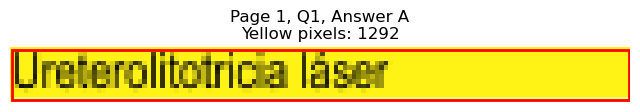

Page 1, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=162.6, y1=127.4
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 482
Page 1, Q1, B: Yellow percentage: 0.0%


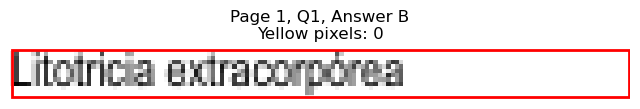

Page 1, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=430.3, y1=114.8
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 533
Page 1, Q1, C: Yellow percentage: 0.0%


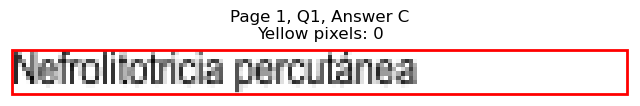

Page 1, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=442.3, y1=127.4
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 596
Page 1, Q1, D: Yellow percentage: 0.0%


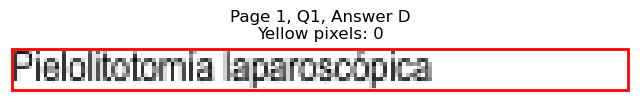


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=202.0, y1=177.9
Page 1, Q2, A: Yellow pixels: 1
Page 1, Q2, A: Total non-white pixels: 829
Page 1, Q2, A: Yellow percentage: 0.1%


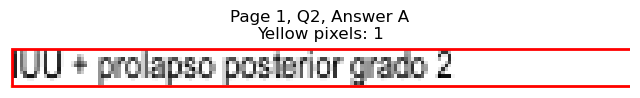

Page 1, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=196.9, y1=190.5
Page 1, Q2, B: Yellow pixels: 1507
Page 1, Q2, B: Total non-white pixels: 2148
Page 1, Q2, B: Yellow percentage: 70.2%


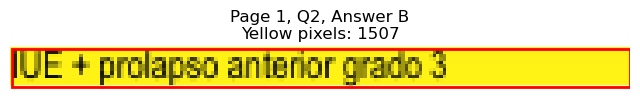

Page 1, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=456.1, y1=177.9
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 625
Page 1, Q2, C: Yellow percentage: 0.0%


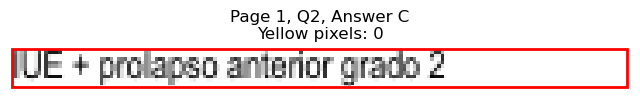

Page 1, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=461.2, y1=190.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 652
Page 1, Q2, D: Yellow percentage: 0.0%


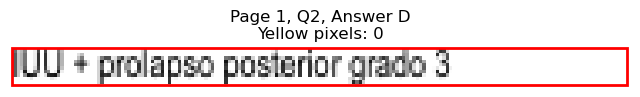


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=107.4, y1=228.4
Page 1, Q3, A: Yellow pixels: 841
Page 1, Q3, A: Total non-white pixels: 1080
Page 1, Q3, A: Yellow percentage: 77.9%


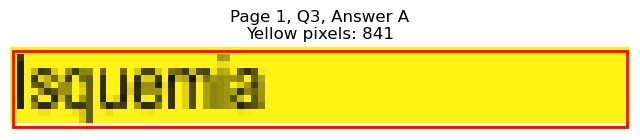

Page 1, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=146.0, y1=241.0
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 402
Page 1, Q3, B: Yellow percentage: 0.0%


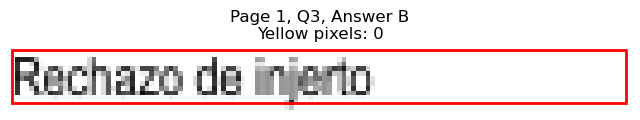

Page 1, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=404.2, y1=228.4
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 386
Page 1, Q3, C: Yellow percentage: 0.0%


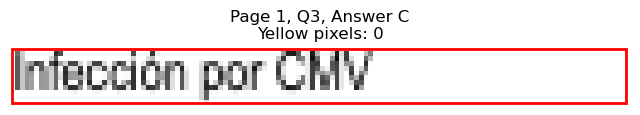

Page 1, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=371.6, y1=241.0
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 228
Page 1, Q3, D: Yellow percentage: 0.0%


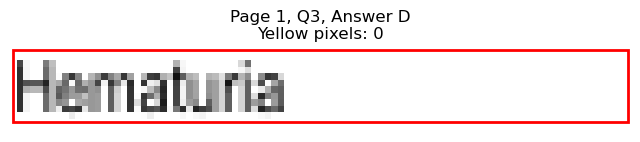


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=124.9, y1=304.2
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 285
Page 1, Q4, A: Yellow percentage: 0.0%


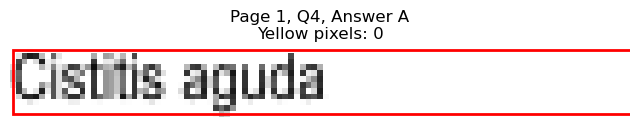

Page 1, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=137.5, y1=316.8
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 347
Page 1, Q4, B: Yellow percentage: 0.0%


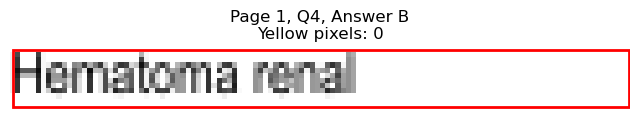

Page 1, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=406.2, y1=304.2
Page 1, Q4, C: Yellow pixels: 130
Page 1, Q4, C: Total non-white pixels: 662
Page 1, Q4, C: Yellow percentage: 19.6%


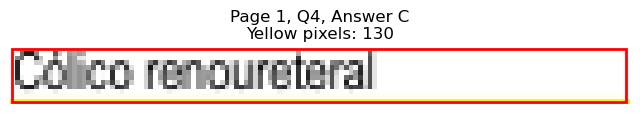

Page 1, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=404.3, y1=316.8
Page 1, Q4, D: Yellow pixels: 1252
Page 1, Q4, D: Total non-white pixels: 1536
Page 1, Q4, D: Yellow percentage: 81.5%


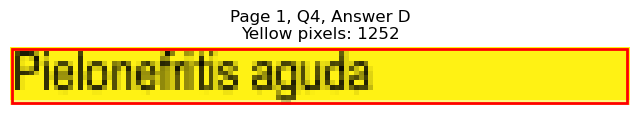


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=88.8, y1=354.7
Page 1, Q5, A: Yellow pixels: 772
Page 1, Q5, A: Total non-white pixels: 852
Page 1, Q5, A: Yellow percentage: 90.6%


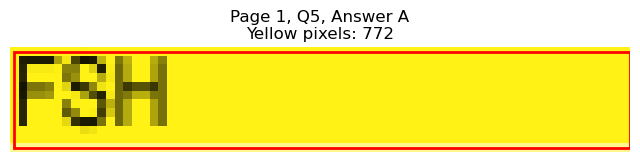

Page 1, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=82.3, y1=367.3
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 57
Page 1, Q5, B: Yellow percentage: 0.0%


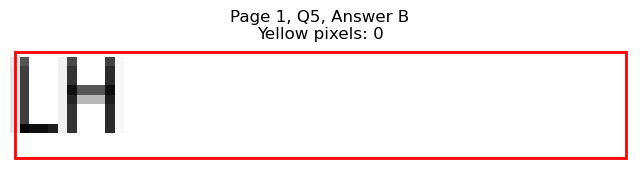

Page 1, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=370.1, y1=354.7
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 200
Page 1, Q5, C: Yellow percentage: 0.0%


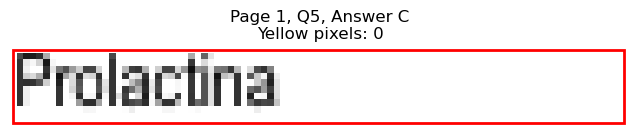

Page 1, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=367.6, y1=367.3
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 202
Page 1, Q5, D: Yellow percentage: 0.0%


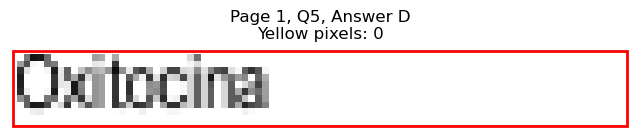


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=88.4, y1=405.1
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 77
Page 1, Q6, A: Yellow percentage: 0.0%


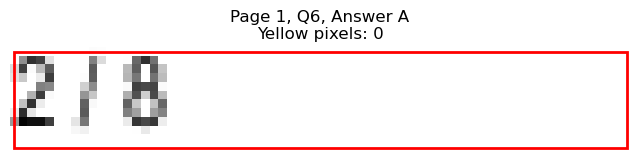

Page 1, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=93.5, y1=417.7
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 89
Page 1, Q6, B: Yellow percentage: 0.0%


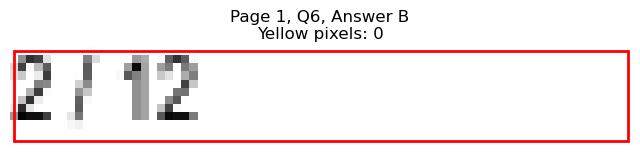

Page 1, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=352.7, y1=405.1
Page 1, Q6, C: Yellow pixels: 76
Page 1, Q6, C: Total non-white pixels: 249
Page 1, Q6, C: Yellow percentage: 30.5%


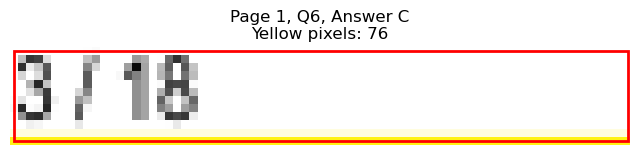

Page 1, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=347.6, y1=417.7
Page 1, Q6, D: Yellow pixels: 795
Page 1, Q6, D: Total non-white pixels: 852
Page 1, Q6, D: Yellow percentage: 93.3%


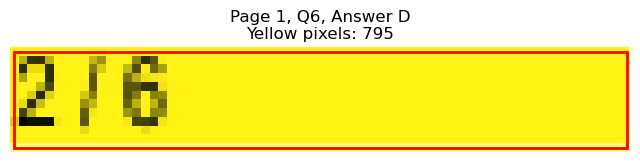


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=457.2, x1=168.1, y1=468.2
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 529
Page 1, Q7, A: Yellow percentage: 0.0%


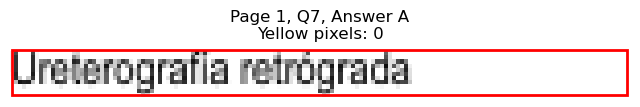

Page 1, Q7 - B: Detected box: x0=68.3, y0=469.8, x1=175.1, y1=480.8
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 569
Page 1, Q7, B: Yellow percentage: 0.0%


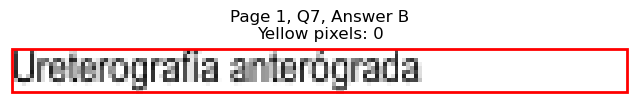

Page 1, Q7 - C: Detected box: x0=327.5, y0=457.2, x1=438.4, y1=468.2
Page 1, Q7, C: Yellow pixels: 1373
Page 1, Q7, C: Total non-white pixels: 1784
Page 1, Q7, C: Yellow percentage: 77.0%


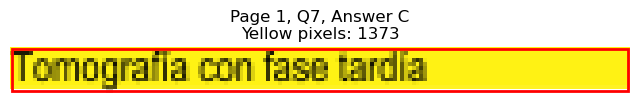

Page 1, Q7 - D: Detected box: x0=327.5, y0=469.8, x1=421.9, y1=480.8
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 487
Page 1, Q7, D: Yellow percentage: 0.0%


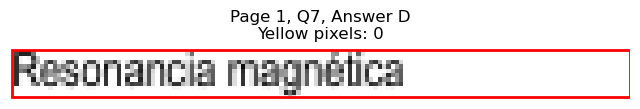


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=507.7, x1=362.8, y1=518.7
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 1450
Page 1, Q8, A: Yellow percentage: 0.0%


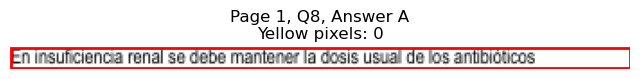

Page 1, Q8 - B: Detected box: x0=68.3, y0=520.3, x1=416.8, y1=531.3
Page 1, Q8, B: Yellow pixels: 399
Page 1, Q8, B: Total non-white pixels: 2115
Page 1, Q8, B: Yellow percentage: 18.9%


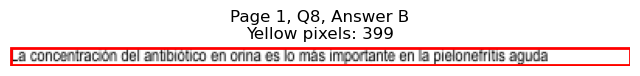

Page 1, Q8 - C: Detected box: x0=68.8, y0=532.9, x1=410.3, y1=543.9
Page 1, Q8, C: Yellow pixels: 3452
Page 1, Q8, C: Total non-white pixels: 4716
Page 1, Q8, C: Yellow percentage: 73.2%


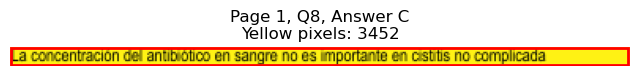

Page 1, Q8 - D: Detected box: x0=68.8, y0=545.5, x1=411.8, y1=556.5
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 1752
Page 1, Q8, D: Yellow percentage: 0.0%


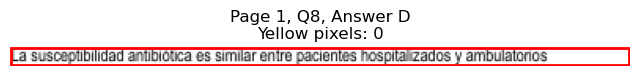


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=583.4, x1=261.8, y1=594.4
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 947
Page 1, Q9, A: Yellow percentage: 0.0%


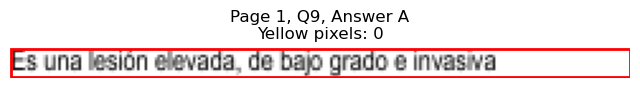

Page 1, Q9 - B: Detected box: x0=68.3, y0=596.0, x1=244.3, y1=607.0
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 912
Page 1, Q9, B: Yellow percentage: 0.0%


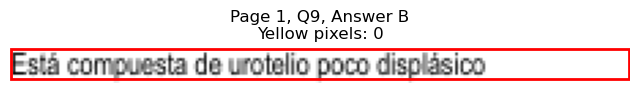

Page 1, Q9 - C: Detected box: x0=327.5, y0=583.4, x1=505.6, y1=594.4
Page 1, Q9, C: Yellow pixels: 1699
Page 1, Q9, C: Total non-white pixels: 2556
Page 1, Q9, C: Yellow percentage: 66.5%


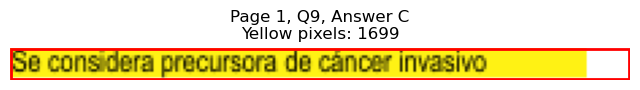

Page 1, Q9 - D: Detected box: x0=327.5, y0=596.0, x1=497.9, y1=607.0
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 794
Page 1, Q9, D: Yellow percentage: 0.0%


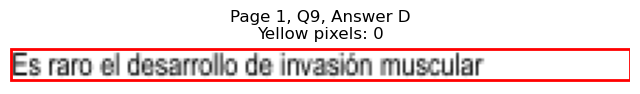


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=646.5, x1=133.4, y1=657.6
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 321
Page 1, Q10, A: Yellow percentage: 0.0%


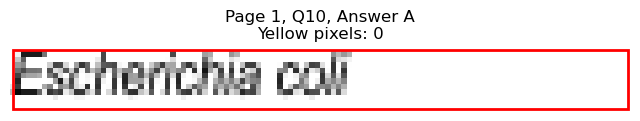

Page 1, Q10 - B: Detected box: x0=68.3, y0=659.1, x1=140.0, y1=670.2
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 372
Page 1, Q10, B: Yellow percentage: 0.0%


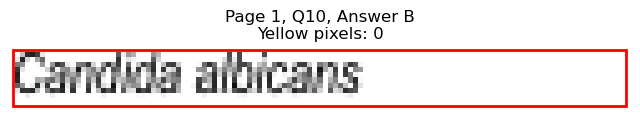

Page 1, Q10 - C: Detected box: x0=327.5, y0=646.5, x1=427.3, y1=657.6
Page 1, Q10, C: Yellow pixels: 1248
Page 1, Q10, C: Total non-white pixels: 1812
Page 1, Q10, C: Yellow percentage: 68.9%


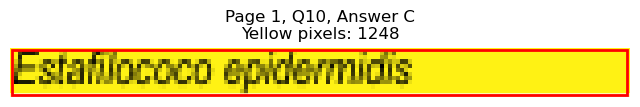

Page 1, Q10 - D: Detected box: x0=327.5, y0=659.1, x1=433.3, y1=670.2
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 564
Page 1, Q10, D: Yellow percentage: 0.0%


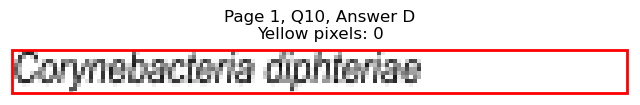


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=722.2, x1=97.9, y1=733.3
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 152
Page 1, Q11, A: Yellow percentage: 0.0%


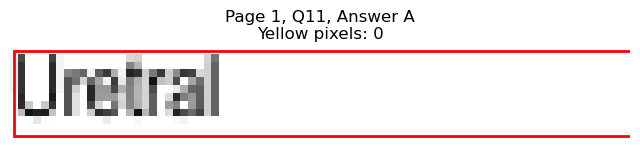

Page 1, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=118.4, y1=745.9
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 253
Page 1, Q11, B: Yellow percentage: 0.0%


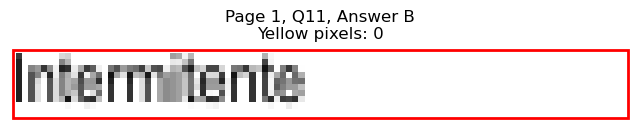

Page 1, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=380.6, y1=733.3
Page 1, Q11, C: Yellow pixels: 956
Page 1, Q11, C: Total non-white pixels: 1248
Page 1, Q11, C: Yellow percentage: 76.6%


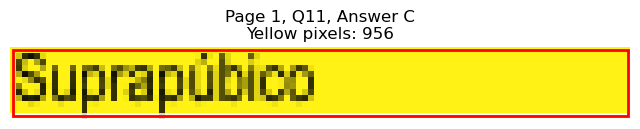

Page 1, Q11 - D: Detected box: x0=327.5, y0=734.8, x1=392.8, y1=745.9
Page 1, Q11, D: Yellow pixels: 0
Page 1, Q11, D: Total non-white pixels: 349
Page 1, Q11, D: Yellow percentage: 0.0%


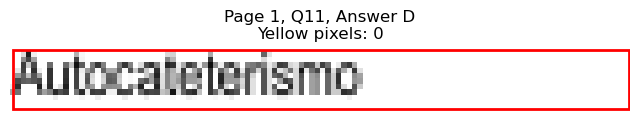


Page 1, Q11 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=133.4, y1=102.2
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 321
Page 2, Q1, A: Yellow percentage: 0.0%


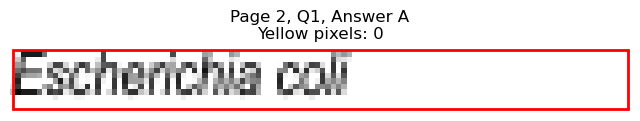

Page 2, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=176.6, y1=114.8
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 567
Page 2, Q1, B: Yellow percentage: 0.0%


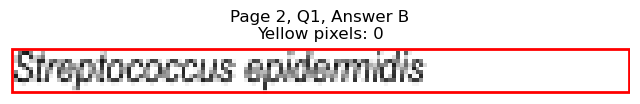

Page 2, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=423.2, y1=102.2
Page 2, Q1, C: Yellow pixels: 1256
Page 2, Q1, C: Total non-white pixels: 1620
Page 2, Q1, C: Yellow percentage: 77.5%


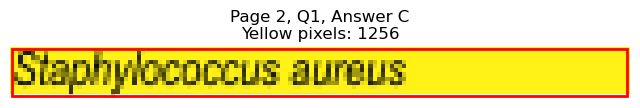

Page 2, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=420.7, y1=114.8
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 493
Page 2, Q1, D: Yellow percentage: 0.0%


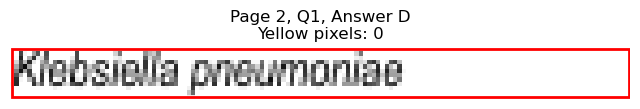


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=115.4, y1=177.9
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 222
Page 2, Q2, A: Yellow percentage: 0.0%


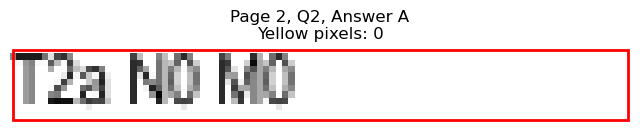

Page 2, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=115.4, y1=190.5
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 216
Page 2, Q2, B: Yellow percentage: 0.0%


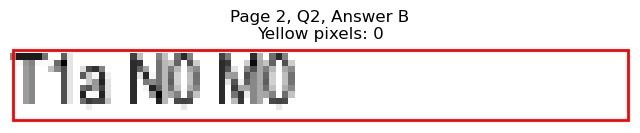

Page 2, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=374.6, y1=177.9
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 329
Page 2, Q2, C: Yellow percentage: 0.0%


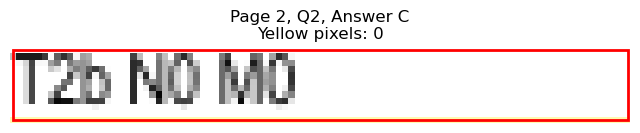

Page 2, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=374.6, y1=190.5
Page 2, Q2, D: Yellow pixels: 887
Page 2, Q2, D: Total non-white pixels: 1176
Page 2, Q2, D: Yellow percentage: 75.4%


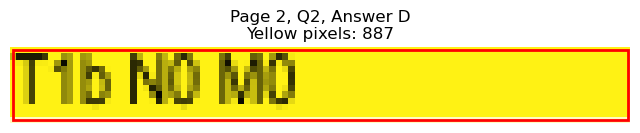


Page 2, Q2 - Selected Answer: D (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=132.0, y1=266.2
Page 2, Q3, A: Yellow pixels: 1024
Page 2, Q3, A: Total non-white pixels: 1254
Page 2, Q3, A: Yellow percentage: 81.7%


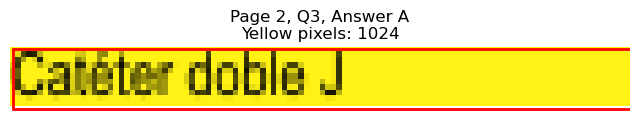

Page 2, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=149.5, y1=278.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 402
Page 2, Q3, B: Yellow percentage: 0.0%


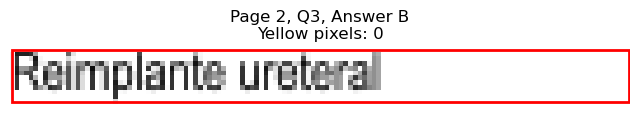

Page 2, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=386.2, y1=266.2
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 286
Page 2, Q3, C: Yellow percentage: 0.0%


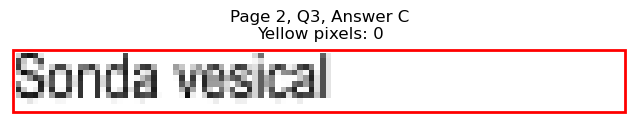

Page 2, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=396.7, y1=278.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 372
Page 2, Q3, D: Yellow percentage: 0.0%


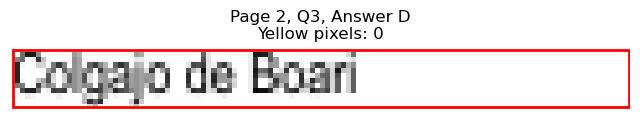


Page 2, Q3 - Selected Answer: A (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=165.1, y1=316.8
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 471
Page 2, Q4, A: Yellow percentage: 0.0%


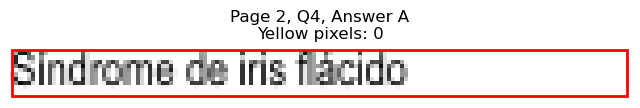

Page 2, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=171.6, y1=329.4
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 533
Page 2, Q4, B: Yellow percentage: 0.0%


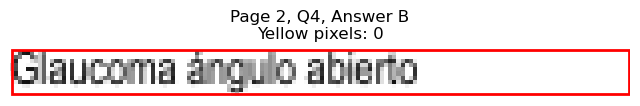

Page 2, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=435.8, y1=316.8
Page 2, Q4, C: Yellow pixels: 159
Page 2, Q4, C: Total non-white pixels: 717
Page 2, Q4, C: Yellow percentage: 22.2%


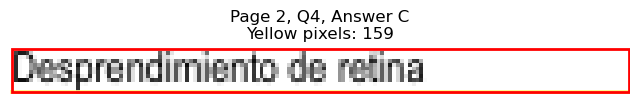

Page 2, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=433.8, y1=329.4
Page 2, Q4, D: Yellow pixels: 1331
Page 2, Q4, D: Total non-white pixels: 1884
Page 2, Q4, D: Yellow percentage: 70.6%


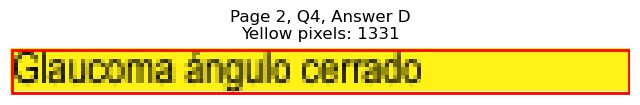


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=141.0, y1=379.9
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 360
Page 2, Q5, A: Yellow percentage: 0.0%


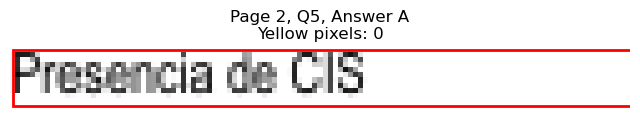

Page 2, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=174.1, y1=392.5
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 544
Page 2, Q5, B: Yellow percentage: 0.0%


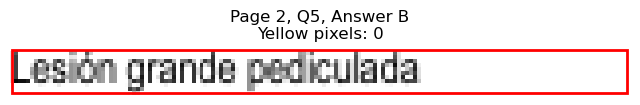

Page 2, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=459.4, y1=379.9
Page 2, Q5, C: Yellow pixels: 1716
Page 2, Q5, C: Total non-white pixels: 2196
Page 2, Q5, C: Yellow percentage: 78.1%


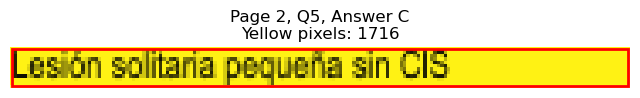

Page 2, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=446.4, y1=392.5
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 605
Page 2, Q5, D: Yellow percentage: 0.0%


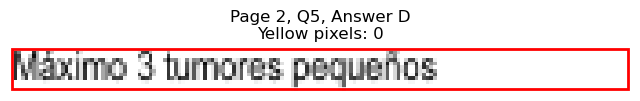


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=125.4, y1=430.4
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 315
Page 2, Q6, A: Yellow percentage: 0.0%


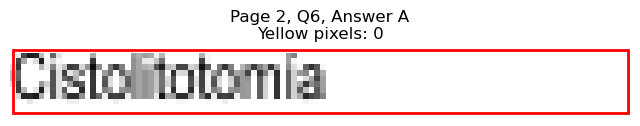

Page 2, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=121.9, y1=443.0
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 298
Page 2, Q6, B: Yellow percentage: 0.0%


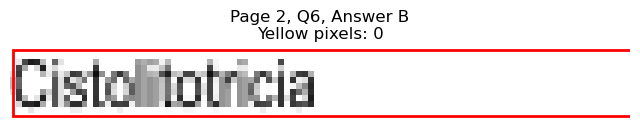

Page 2, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=390.7, y1=430.4
Page 2, Q6, C: Yellow pixels: 1001
Page 2, Q6, C: Total non-white pixels: 1368
Page 2, Q6, C: Yellow percentage: 73.2%


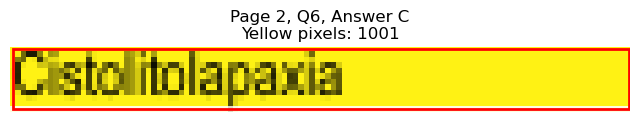

Page 2, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=377.6, y1=443.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 267
Page 2, Q6, D: Yellow percentage: 0.0%


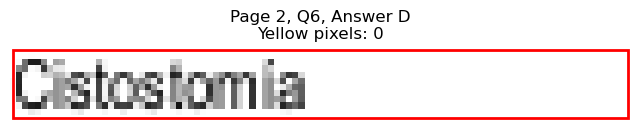


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=482.5, x1=80.9, y1=493.5
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 51
Page 2, Q7, A: Yellow percentage: 0.0%


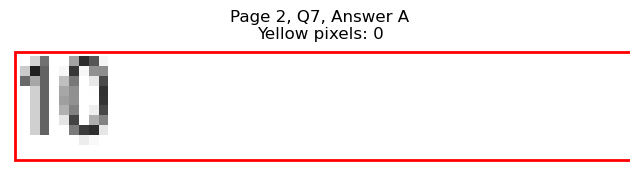

Page 2, Q7 - B: Detected box: x0=68.3, y0=495.1, x1=80.9, y1=506.1
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 60
Page 2, Q7, B: Yellow percentage: 0.0%


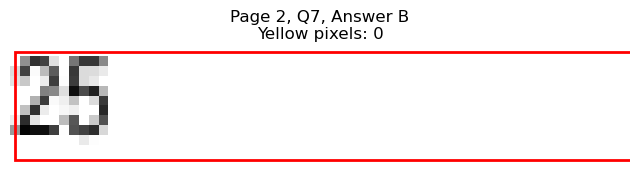

Page 2, Q7 - C: Detected box: x0=327.5, y0=482.5, x1=340.1, y1=493.5
Page 2, Q7, C: Yellow pixels: 664
Page 2, Q7, C: Total non-white pixels: 768
Page 2, Q7, C: Yellow percentage: 86.5%


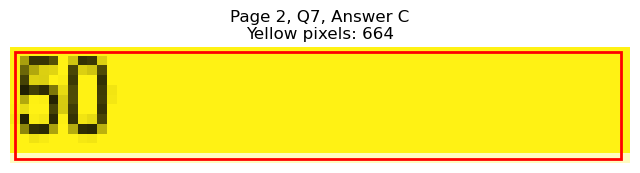

Page 2, Q7 - D: Detected box: x0=327.5, y0=495.1, x1=340.1, y1=506.1
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 65
Page 2, Q7, D: Yellow percentage: 0.0%


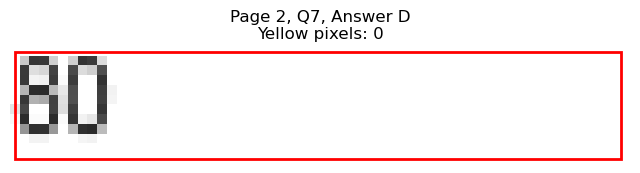


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=134.0, y1=556.5
Page 2, Q8, A: Yellow pixels: 117
Page 2, Q8, A: Total non-white pixels: 441
Page 2, Q8, A: Yellow percentage: 26.5%


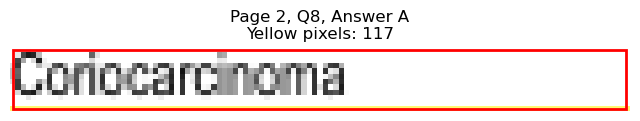

Page 2, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=102.8, y1=569.2
Page 2, Q8, B: Yellow pixels: 824
Page 2, Q8, B: Total non-white pixels: 935
Page 2, Q8, B: Yellow percentage: 88.1%


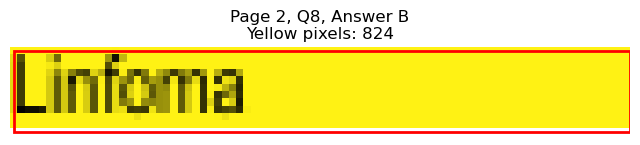

Page 2, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=373.1, y1=556.5
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 231
Page 2, Q8, C: Yellow percentage: 0.0%


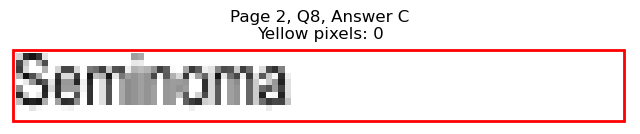

Page 2, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=368.6, y1=569.2
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 204
Page 2, Q8, D: Yellow percentage: 0.0%


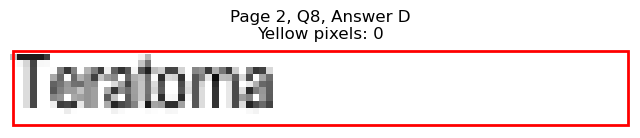


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=596.0, x1=112.9, y1=607.0
Page 2, Q9, A: Yellow pixels: 986
Page 2, Q9, A: Total non-white pixels: 1143
Page 2, Q9, A: Yellow percentage: 86.3%


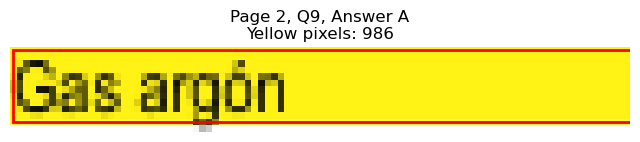

Page 2, Q9 - B: Detected box: x0=68.3, y0=608.6, x1=110.0, y1=619.6
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 231
Page 2, Q9, B: Yellow percentage: 0.0%


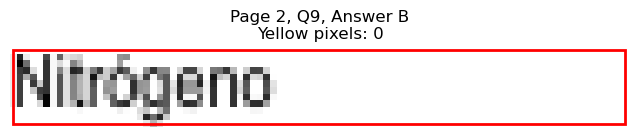

Page 2, Q9 - C: Detected box: x0=327.5, y0=596.0, x1=393.2, y1=607.0
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 331
Page 2, Q9, C: Yellow percentage: 0.0%


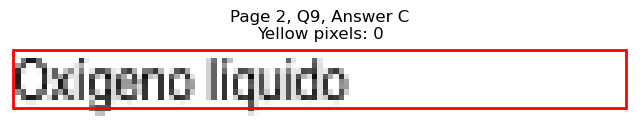

Page 2, Q9 - D: Detected box: x0=327.5, y0=608.6, x1=390.7, y1=619.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 319
Page 2, Q9, D: Yellow percentage: 0.0%


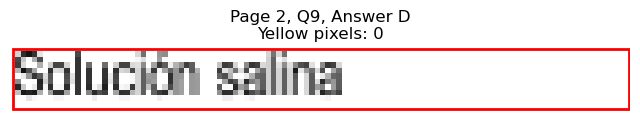


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=646.5, x1=180.1, y1=657.6
Page 2, Q10, A: Yellow pixels: 163
Page 2, Q10, A: Total non-white pixels: 721
Page 2, Q10, A: Yellow percentage: 22.6%


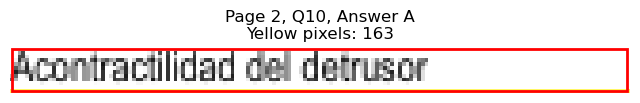

Page 2, Q10 - B: Detected box: x0=68.3, y0=659.1, x1=178.1, y1=670.2
Page 2, Q10, B: Yellow pixels: 1338
Page 2, Q10, B: Total non-white pixels: 1773
Page 2, Q10, B: Yellow percentage: 75.5%


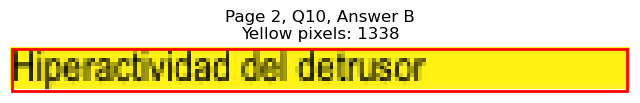

Page 2, Q10 - C: Detected box: x0=327.5, y0=646.5, x1=444.8, y1=657.6
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 612
Page 2, Q10, C: Yellow percentage: 0.0%


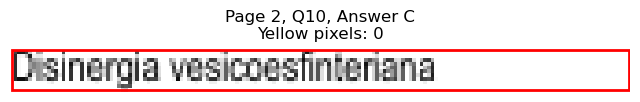

Page 2, Q10 - D: Detected box: x0=327.5, y0=659.1, x1=425.8, y1=670.2
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 550
Page 2, Q10, D: Yellow percentage: 0.0%


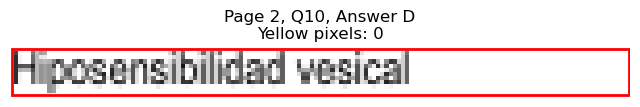


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=722.2, x1=230.8, y1=733.3
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 783
Page 2, Q11, A: Yellow percentage: 0.0%


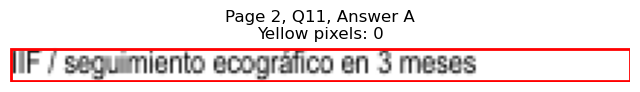

Page 2, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=222.7, y1=745.9
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 746
Page 2, Q11, B: Yellow percentage: 0.0%


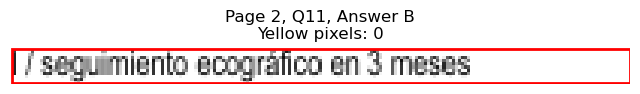

Page 2, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=462.5, y1=733.3
Page 2, Q11, C: Yellow pixels: 1555
Page 2, Q11, C: Total non-white pixels: 2232
Page 2, Q11, C: Yellow percentage: 69.7%


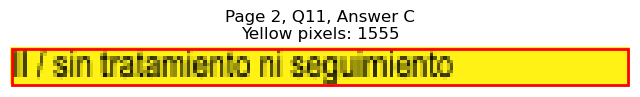

Page 2, Q11 - D: Detected box: x0=327.5, y0=734.8, x1=467.9, y1=745.9
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 698
Page 2, Q11, D: Yellow percentage: 0.0%


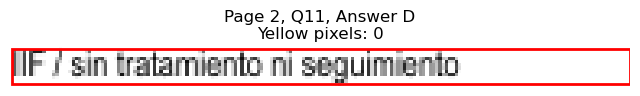


Page 2, Q11 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 12 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=188.6, y1=114.8
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 597
Page 3, Q1, A: Yellow percentage: 0.0%


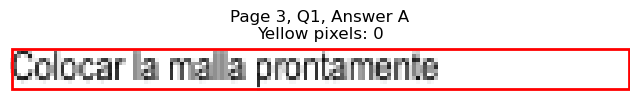

Page 3, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=230.8, y1=127.4
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 809
Page 3, Q1, B: Yellow percentage: 0.0%


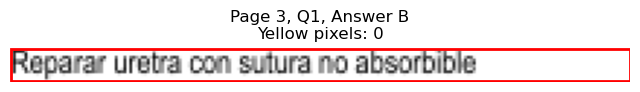

Page 3, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=469.0, y1=114.8
Page 3, Q1, C: Yellow pixels: 192
Page 3, Q1, C: Total non-white pixels: 933
Page 3, Q1, C: Yellow percentage: 20.6%


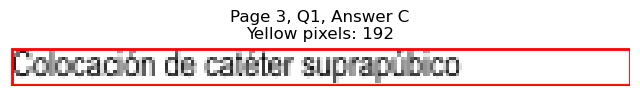

Page 3, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=474.5, y1=127.4
Page 3, Q1, D: Yellow pixels: 1614
Page 3, Q1, D: Total non-white pixels: 2376
Page 3, Q1, D: Yellow percentage: 67.9%


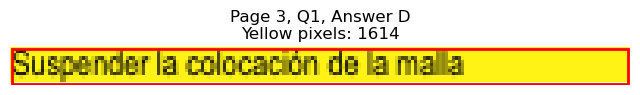


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=211.9, y1=177.9
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 749
Page 3, Q2, A: Yellow percentage: 0.0%


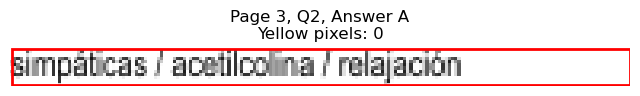

Page 3, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=247.9, y1=190.5
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 918
Page 3, Q2, B: Yellow percentage: 0.0%


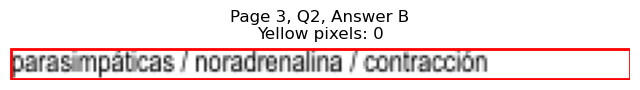

Page 3, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=496.6, y1=177.9
Page 3, Q2, C: Yellow pixels: 1927
Page 3, Q2, C: Total non-white pixels: 2556
Page 3, Q2, C: Yellow percentage: 75.4%


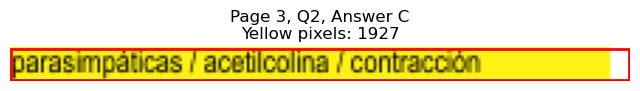

Page 3, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=489.0, y1=190.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 821
Page 3, Q2, D: Yellow percentage: 0.0%


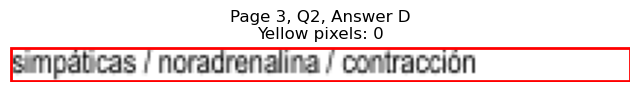


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=457.2, x1=98.4, y1=468.2
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 157
Page 3, Q3, A: Yellow percentage: 0.0%


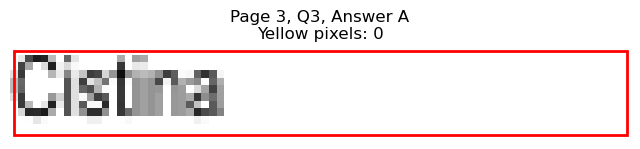

Page 3, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=105.8, y1=253.6
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 200
Page 3, Q3, B: Yellow percentage: 0.0%


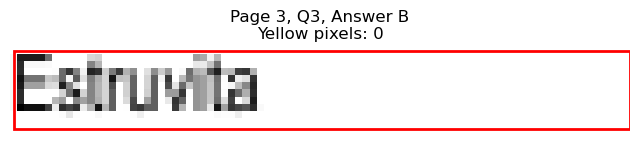

Page 3, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=398.2, y1=241.0
Page 3, Q3, C: Yellow pixels: 122
Page 3, Q3, C: Total non-white pixels: 594
Page 3, Q3, C: Yellow percentage: 20.5%


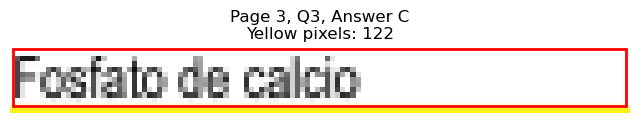

Page 3, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=396.7, y1=253.6
Page 3, Q3, D: Yellow pixels: 1067
Page 3, Q3, D: Total non-white pixels: 1440
Page 3, Q3, D: Yellow percentage: 74.1%


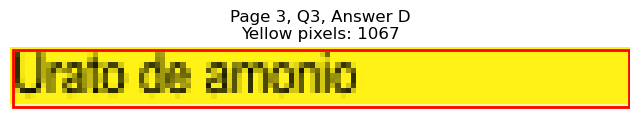


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=170.5, y1=291.6
Page 3, Q4, A: Yellow pixels: 1286
Page 3, Q4, A: Total non-white pixels: 1836
Page 3, Q4, A: Yellow percentage: 70.0%


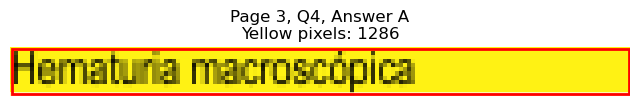

Page 3, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=133.6, y1=304.2
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 328
Page 3, Q4, B: Yellow percentage: 0.0%


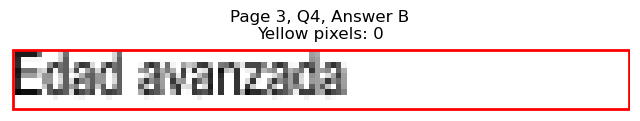

Page 3, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=443.9, y1=291.6
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 603
Page 3, Q4, C: Yellow percentage: 0.0%


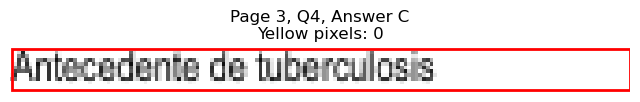

Page 3, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=416.8, y1=304.2
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 457
Page 3, Q4, D: Yellow percentage: 0.0%


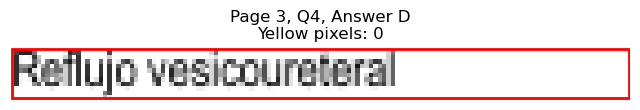


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=100.9, y1=342.0
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 164
Page 3, Q5, A: Yellow percentage: 0.0%


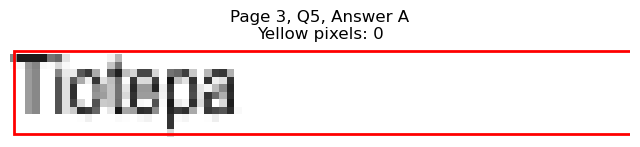

Page 3, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=121.4, y1=354.7
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 283
Page 3, Q5, B: Yellow percentage: 0.0%


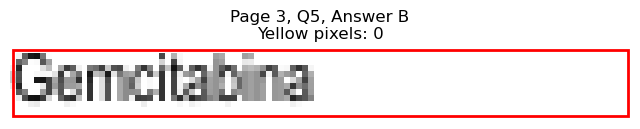

Page 3, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=382.1, y1=342.0
Page 3, Q5, C: Yellow pixels: 1061
Page 3, Q5, C: Total non-white pixels: 1272
Page 3, Q5, C: Yellow percentage: 83.4%


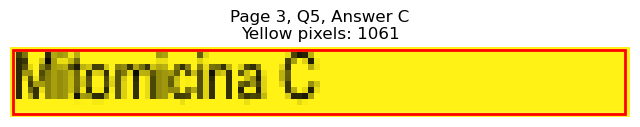

Page 3, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=422.8, y1=354.7
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 498
Page 3, Q5, D: Yellow percentage: 0.0%


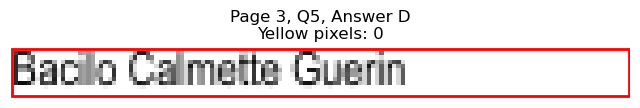


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=105.8, y1=405.1
Page 3, Q6, A: Yellow pixels: 88
Page 3, Q6, A: Total non-white pixels: 359
Page 3, Q6, A: Yellow percentage: 24.5%


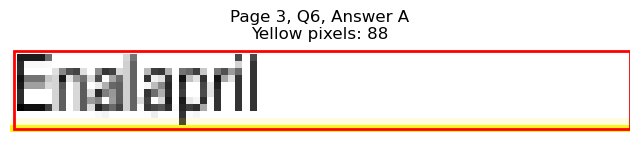

Page 3, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=110.9, y1=417.7
Page 3, Q6, B: Yellow pixels: 965
Page 3, Q6, B: Total non-white pixels: 1116
Page 3, Q6, B: Yellow percentage: 86.5%


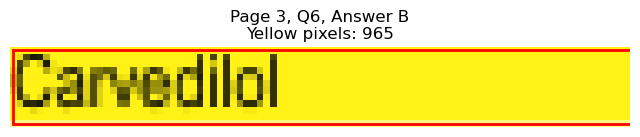

Page 3, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=368.2, y1=405.1
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 199
Page 3, Q6, C: Yellow percentage: 0.0%


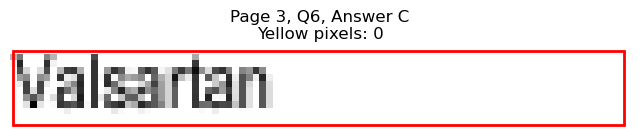

Page 3, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=374.6, y1=417.7
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 253
Page 3, Q6, D: Yellow percentage: 0.0%


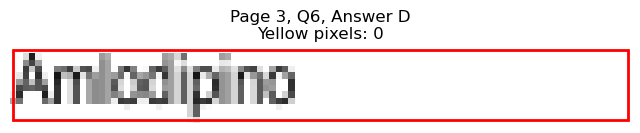


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=457.2, x1=98.4, y1=468.2
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 157
Page 3, Q7, A: Yellow percentage: 0.0%


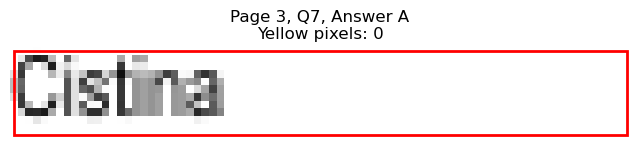

Page 3, Q7 - B: Detected box: x0=68.3, y0=469.8, x1=137.5, y1=480.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 334
Page 3, Q7, B: Yellow percentage: 0.0%


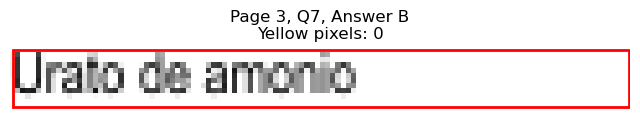

Page 3, Q7 - C: Detected box: x0=327.5, y0=457.2, x1=365.0, y1=468.2
Page 3, Q7, C: Yellow pixels: 89
Page 3, Q7, C: Total non-white pixels: 356
Page 3, Q7, C: Yellow percentage: 25.0%


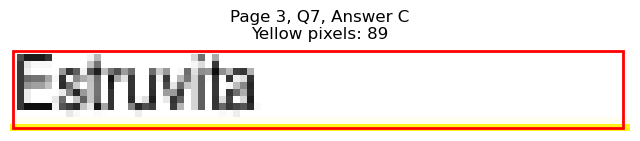

Page 3, Q7 - D: Detected box: x0=327.5, y0=469.8, x1=399.2, y1=480.8
Page 3, Q7, D: Yellow pixels: 1197
Page 3, Q7, D: Total non-white pixels: 1476
Page 3, Q7, D: Yellow percentage: 81.1%


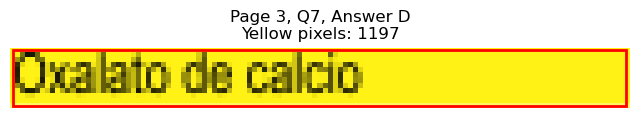


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=520.3, x1=208.7, y1=531.3
Page 3, Q8, A: Yellow pixels: 1584
Page 3, Q8, A: Total non-white pixels: 2292
Page 3, Q8, A: Yellow percentage: 69.1%


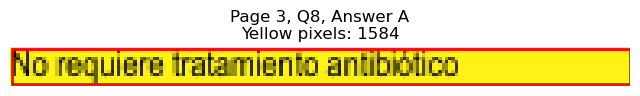

Page 3, Q8 - B: Detected box: x0=68.3, y0=532.9, x1=267.4, y1=543.9
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 1046
Page 3, Q8, B: Yellow percentage: 0.0%


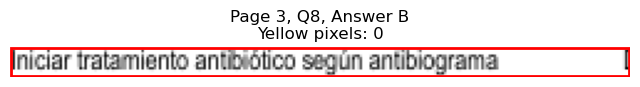

Page 3, Q8 - C: Detected box: x0=327.5, y0=520.3, x1=433.3, y1=531.3
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 484
Page 3, Q8, C: Yellow percentage: 0.0%


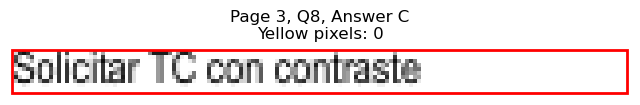

Page 3, Q8 - D: Detected box: x0=327.5, y0=532.9, x1=476.4, y1=543.9
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 784
Page 3, Q8, D: Yellow percentage: 0.0%


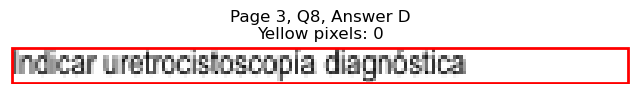


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=570.8, x1=120.5, y1=581.8
Page 3, Q9, A: Yellow pixels: 1043
Page 3, Q9, A: Total non-white pixels: 1236
Page 3, Q9, A: Yellow percentage: 84.4%


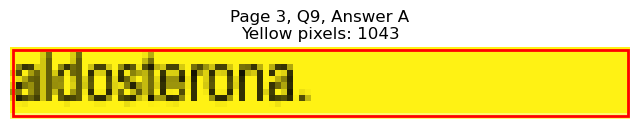

Page 3, Q9 - B: Detected box: x0=68.3, y0=583.4, x1=128.5, y1=594.4
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 265
Page 3, Q9, B: Yellow percentage: 0.0%


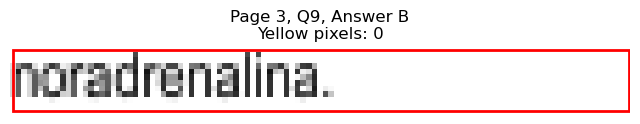

Page 3, Q9 - C: Detected box: x0=327.5, y0=570.8, x1=409.2, y1=581.8
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 416
Page 3, Q9, C: Yellow percentage: 0.0%


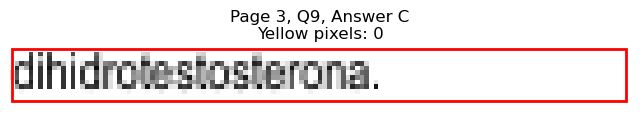

Page 3, Q9 - D: Detected box: x0=327.5, y0=583.4, x1=361.1, y1=594.4
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 159
Page 3, Q9, D: Yellow percentage: 0.0%


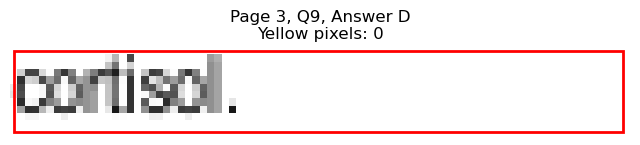


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=633.9, x1=106.4, y1=645.0
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 267
Page 3, Q10, A: Yellow percentage: 0.0%


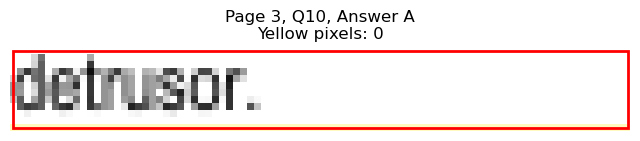

Page 3, Q10 - B: Detected box: x0=68.3, y0=646.5, x1=100.9, y1=657.6
Page 3, Q10, B: Yellow pixels: 789
Page 3, Q10, B: Total non-white pixels: 996
Page 3, Q10, B: Yellow percentage: 79.2%


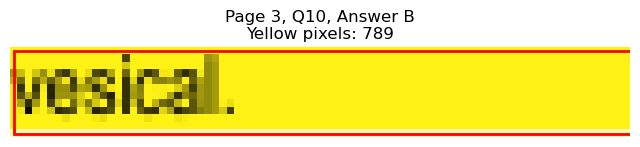

Page 3, Q10 - C: Detected box: x0=327.5, y0=633.9, x1=358.1, y1=645.0
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 136
Page 3, Q10, C: Yellow percentage: 0.0%


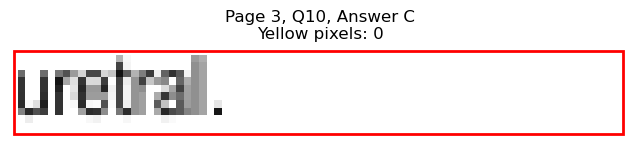

Page 3, Q10 - D: Detected box: x0=327.5, y0=646.5, x1=374.2, y1=657.6
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 226
Page 3, Q10, D: Yellow percentage: 0.0%


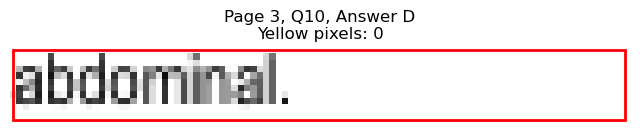


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=684.3, x1=160.6, y1=695.4
Page 3, Q11, A: Yellow pixels: 0
Page 3, Q11, A: Total non-white pixels: 448
Page 3, Q11, A: Yellow percentage: 0.0%


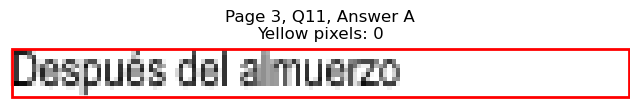

Page 3, Q11 - B: Detected box: x0=68.3, y0=697.0, x1=181.1, y1=708.1
Page 3, Q11, B: Yellow pixels: 0
Page 3, Q11, B: Total non-white pixels: 553
Page 3, Q11, B: Yellow percentage: 0.0%


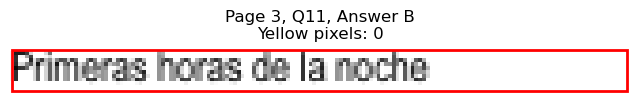

Page 3, Q11 - C: Detected box: x0=327.5, y0=684.3, x1=409.8, y1=695.4
Page 3, Q11, C: Yellow pixels: 133
Page 3, Q11, C: Total non-white pixels: 528
Page 3, Q11, C: Yellow percentage: 25.2%


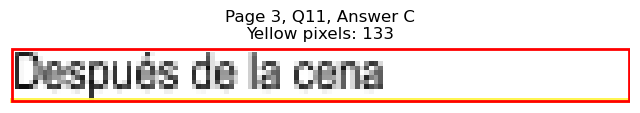

Page 3, Q11 - D: Detected box: x0=327.5, y0=697.0, x1=428.3, y1=708.1
Page 3, Q11, D: Yellow pixels: 1331
Page 3, Q11, D: Total non-white pixels: 1673
Page 3, Q11, D: Yellow percentage: 79.6%


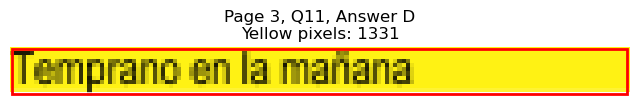


Page 3, Q11 - Selected Answer: D (based on yellow pixel count)




Page 3, Q12 - A: Detected box: x0=68.3, y0=734.8, x1=195.2, y1=745.9
Page 3, Q12, A: Yellow pixels: 1682
Page 3, Q12, A: Total non-white pixels: 2136
Page 3, Q12, A: Yellow percentage: 78.7%


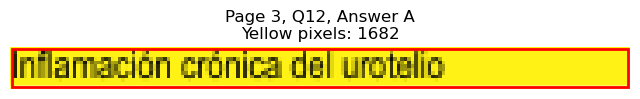

Page 3, Q12 - B: Detected box: x0=68.3, y0=747.4, x1=120.5, y1=758.5
Page 3, Q12, B: Yellow pixels: 0
Page 3, Q12, B: Total non-white pixels: 272
Page 3, Q12, B: Yellow percentage: 0.0%


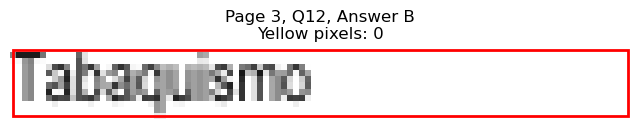

Page 3, Q12 - C: Detected box: x0=327.5, y0=734.8, x1=430.8, y1=745.9
Page 3, Q12, C: Yellow pixels: 0
Page 3, Q12, C: Total non-white pixels: 532
Page 3, Q12, C: Yellow percentage: 0.0%


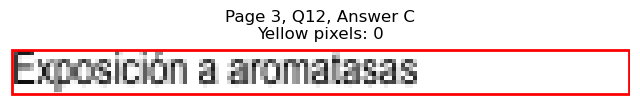

Page 3, Q12 - D: Detected box: x0=327.5, y0=747.4, x1=396.2, y1=758.5
Page 3, Q12, D: Yellow pixels: 0
Page 3, Q12, D: Total non-white pixels: 385
Page 3, Q12, D: Yellow percentage: 0.0%


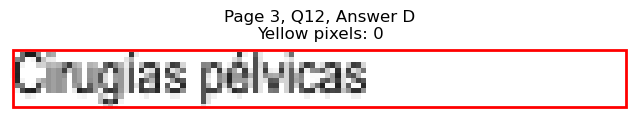


Page 3, Q12 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=235.3, y1=102.2
Page 4, Q1, A: Yellow pixels: 1700
Page 4, Q1, A: Total non-white pixels: 2361
Page 4, Q1, A: Yellow percentage: 72.0%


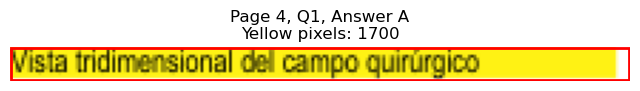

Page 4, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=252.4, y1=114.8
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 922
Page 4, Q1, B: Yellow percentage: 0.0%


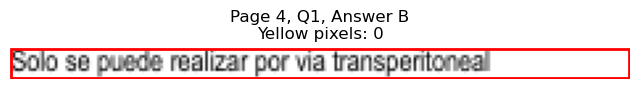

Page 4, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=456.4, y1=102.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 644
Page 4, Q1, C: Yellow percentage: 0.0%


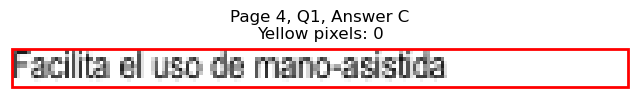

Page 4, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=497.5, y1=114.8
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 837
Page 4, Q1, D: Yellow percentage: 0.0%


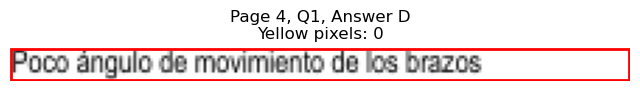


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=127.9, y1=165.3
Page 4, Q2, A: Yellow pixels: 110
Page 4, Q2, A: Total non-white pixels: 408
Page 4, Q2, A: Yellow percentage: 27.0%


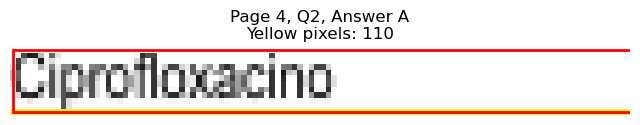

Page 4, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=130.0, y1=177.9
Page 4, Q2, B: Yellow pixels: 1093
Page 4, Q2, B: Total non-white pixels: 1344
Page 4, Q2, B: Yellow percentage: 81.3%


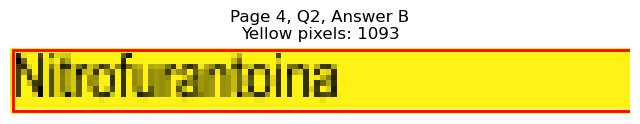

Page 4, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=380.6, y1=165.3
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 269
Page 4, Q2, C: Yellow percentage: 0.0%


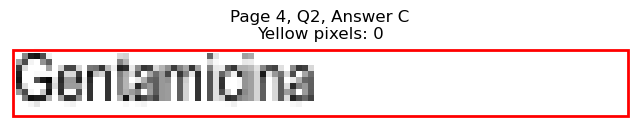

Page 4, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=368.2, y1=177.9
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 215
Page 4, Q2, D: Yellow percentage: 0.0%


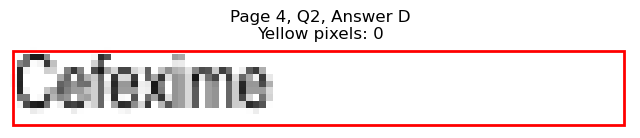


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=104.4, y1=215.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 194
Page 4, Q3, A: Yellow percentage: 0.0%


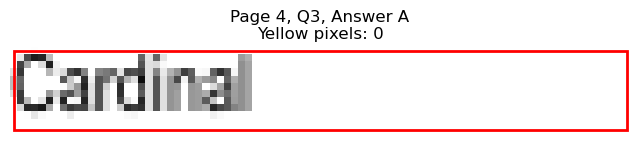

Page 4, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=115.0, y1=228.4
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 236
Page 4, Q3, B: Yellow percentage: 0.0%


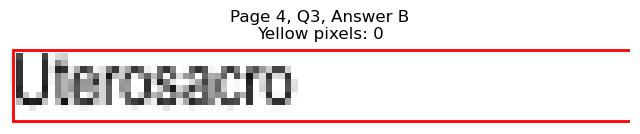

Page 4, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=376.1, y1=215.7
Page 4, Q3, C: Yellow pixels: 1036
Page 4, Q3, C: Total non-white pixels: 1200
Page 4, Q3, C: Yellow percentage: 86.3%


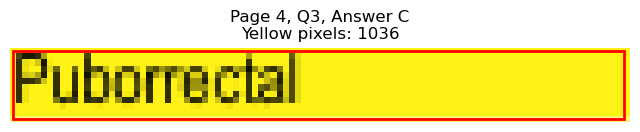

Page 4, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=370.6, y1=228.4
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 220
Page 4, Q3, D: Yellow percentage: 0.0%


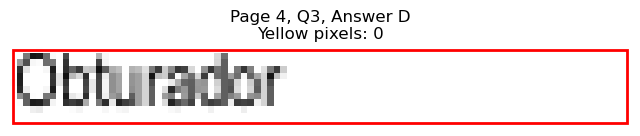


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=116.4, y1=266.2
Page 4, Q4, A: Yellow pixels: 97
Page 4, Q4, A: Total non-white pixels: 353
Page 4, Q4, A: Yellow percentage: 27.5%


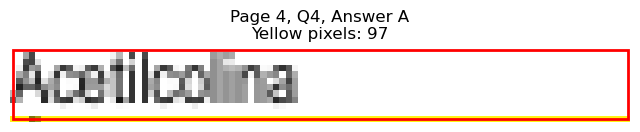

Page 4, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=121.4, y1=278.8
Page 4, Q4, B: Yellow pixels: 1045
Page 4, Q4, B: Total non-white pixels: 1248
Page 4, Q4, B: Yellow percentage: 83.7%


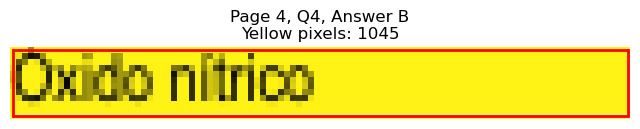

Page 4, Q4 - C: Detected box: x0=327.5, y0=255.2, x1=386.6, y1=266.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 321
Page 4, Q4, C: Yellow percentage: 0.0%


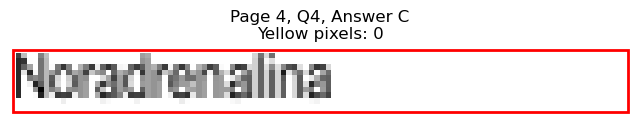

Page 4, Q4 - D: Detected box: x0=327.5, y0=267.8, x1=373.7, y1=278.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 242
Page 4, Q4, D: Yellow percentage: 0.0%


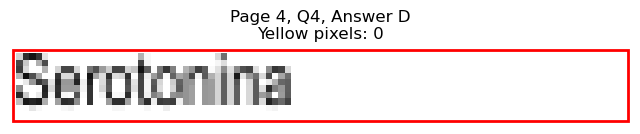


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=56.6, y0=330.9, x1=65.2, y1=342.0
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 64
Page 4, Q5, A: Yellow percentage: 0.0%


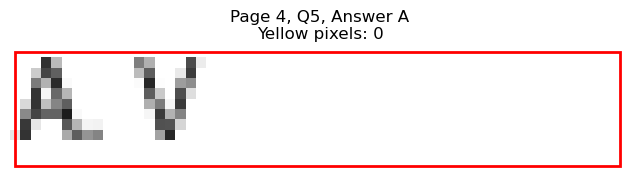

Page 4, Q5 - B: Detected box: x0=56.6, y0=343.6, x1=65.2, y1=354.7
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 66
Page 4, Q5, B: Yellow percentage: 0.0%


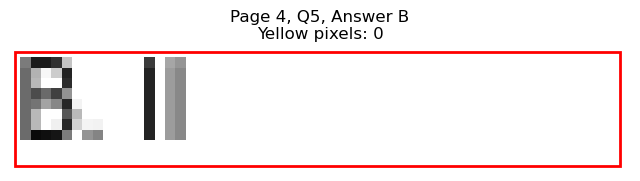

Page 4, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=338.5, y1=342.0
Page 4, Q5, C: Yellow pixels: 704
Page 4, Q5, C: Total non-white pixels: 744
Page 4, Q5, C: Yellow percentage: 94.6%


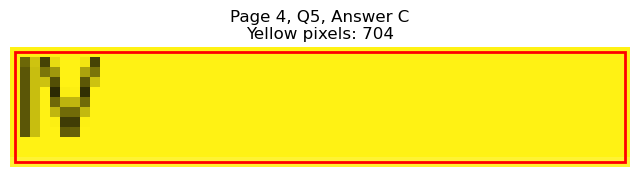

Page 4, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=337.6, y1=354.7
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 48
Page 4, Q5, D: Yellow percentage: 0.0%


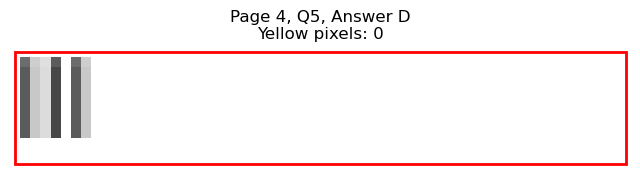


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=189.1, y1=405.1
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 672
Page 4, Q6, A: Yellow percentage: 0.0%


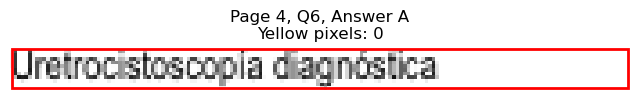

Page 4, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=160.6, y1=417.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 474
Page 4, Q6, B: Yellow percentage: 0.0%


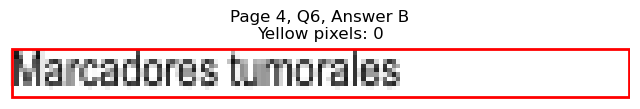

Page 4, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=447.4, y1=405.1
Page 4, Q6, C: Yellow pixels: 1399
Page 4, Q6, C: Total non-white pixels: 1887
Page 4, Q6, C: Yellow percentage: 74.1%


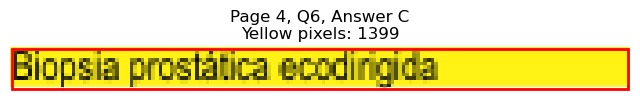

Page 4, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=394.2, y1=417.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 337
Page 4, Q6, D: Yellow percentage: 0.0%


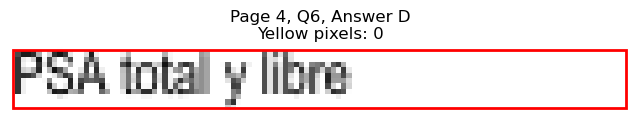


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=444.6, x1=134.0, y1=455.6
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 339
Page 4, Q7, A: Yellow percentage: 0.0%


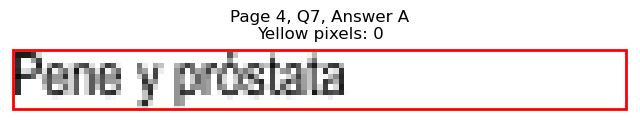

Page 4, Q7 - B: Detected box: x0=68.3, y0=457.2, x1=138.0, y1=468.2
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 378
Page 4, Q7, B: Yellow percentage: 0.0%


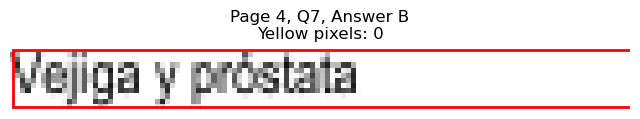

Page 4, Q7 - C: Detected box: x0=327.5, y0=444.6, x1=383.2, y1=455.6
Page 4, Q7, C: Yellow pixels: 107
Page 4, Q7, C: Total non-white pixels: 383
Page 4, Q7, C: Yellow percentage: 27.9%


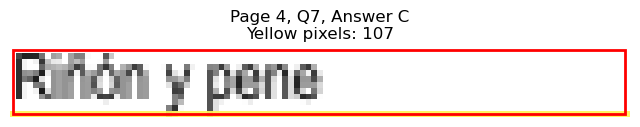

Page 4, Q7 - D: Detected box: x0=327.5, y0=457.2, x1=386.6, y1=468.2
Page 4, Q7, D: Yellow pixels: 966
Page 4, Q7, D: Total non-white pixels: 1218
Page 4, Q7, D: Yellow percentage: 79.3%


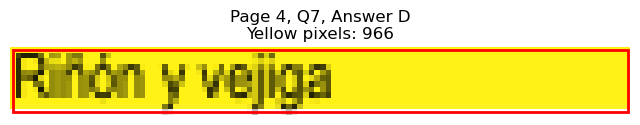


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=495.1, x1=240.4, y1=506.1
Page 4, Q8, A: Yellow pixels: 213
Page 4, Q8, A: Total non-white pixels: 1278
Page 4, Q8, A: Yellow percentage: 16.7%


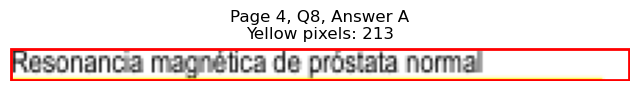

Page 4, Q8 - B: Detected box: x0=68.3, y0=507.7, x1=214.8, y1=518.7
Page 4, Q8, B: Yellow pixels: 1795
Page 4, Q8, B: Total non-white pixels: 2364
Page 4, Q8, B: Yellow percentage: 75.9%


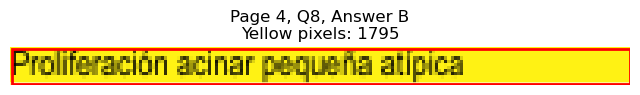

Page 4, Q8 - C: Detected box: x0=327.5, y0=495.1, x1=401.8, y1=506.1
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 353
Page 4, Q8, C: Yellow percentage: 0.0%


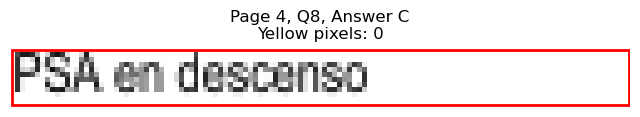

Page 4, Q8 - D: Detected box: x0=327.5, y0=507.7, x1=422.8, y1=518.7
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 449
Page 4, Q8, D: Yellow percentage: 0.0%


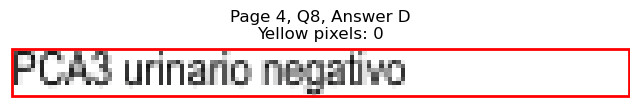


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=545.5, x1=310.4, y1=556.5
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 1204
Page 4, Q9, A: Yellow percentage: 0.0%


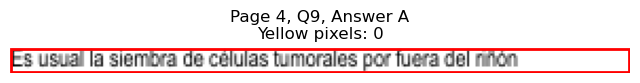

Page 4, Q9 - B: Detected box: x0=68.3, y0=558.2, x1=311.0, y1=569.2
Page 4, Q9, B: Yellow pixels: 294
Page 4, Q9, B: Total non-white pixels: 1489
Page 4, Q9, B: Yellow percentage: 19.7%


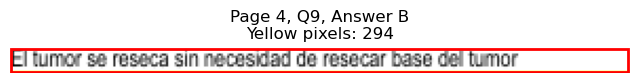

Page 4, Q9 - C: Detected box: x0=68.8, y0=570.8, x1=216.7, y1=581.8
Page 4, Q9, C: Yellow pixels: 1835
Page 4, Q9, C: Total non-white pixels: 2388
Page 4, Q9, C: Yellow percentage: 76.8%


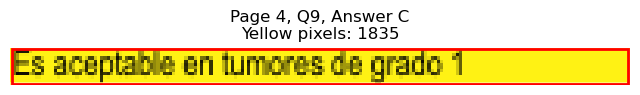

Page 4, Q9 - D: Detected box: x0=68.8, y0=583.4, x1=244.8, y1=594.4
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 874
Page 4, Q9, D: Yellow percentage: 0.0%


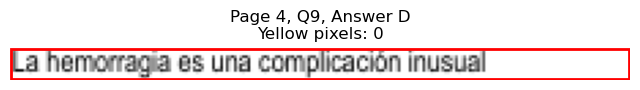


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=633.9, x1=136.4, y1=645.0
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 321
Page 4, Q10, A: Yellow percentage: 0.0%


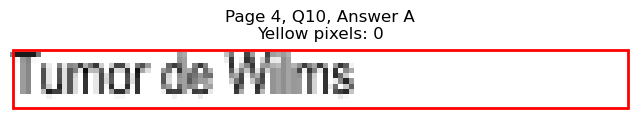

Page 4, Q10 - B: Detected box: x0=68.3, y0=646.5, x1=160.1, y1=657.6
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 455
Page 4, Q10, B: Yellow percentage: 0.0%


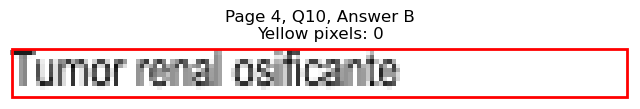

Page 4, Q10 - C: Detected box: x0=327.5, y0=633.9, x1=435.8, y1=645.0
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 701
Page 4, Q10, C: Yellow percentage: 0.0%


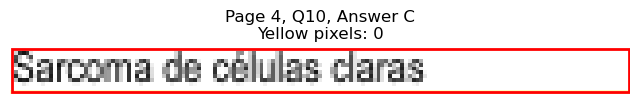

Page 4, Q10 - D: Detected box: x0=327.5, y0=646.5, x1=461.3, y1=657.6
Page 4, Q10, D: Yellow pixels: 1525
Page 4, Q10, D: Total non-white pixels: 2220
Page 4, Q10, D: Yellow percentage: 68.7%


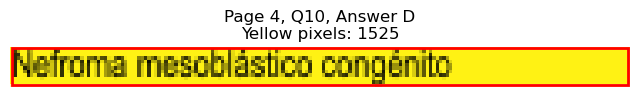


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=684.3, x1=304.1, y1=695.4
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 1164
Page 4, Q11, A: Yellow percentage: 0.0%


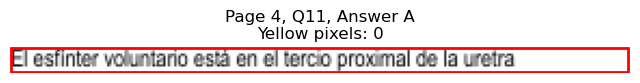

Page 4, Q11 - B: Detected box: x0=68.3, y0=697.0, x1=252.4, y1=708.1
Page 4, Q11, B: Yellow pixels: 235
Page 4, Q11, B: Total non-white pixels: 1372
Page 4, Q11, B: Yellow percentage: 17.1%


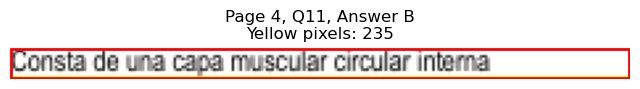

Page 4, Q11 - C: Detected box: x0=68.8, y0=709.6, x1=305.9, y1=720.7
Page 4, Q11, C: Yellow pixels: 2543
Page 4, Q11, C: Total non-white pixels: 3456
Page 4, Q11, C: Yellow percentage: 73.6%


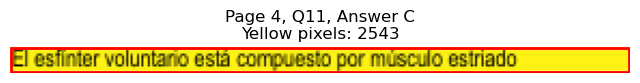

Page 4, Q11 - D: Detected box: x0=68.8, y0=722.2, x1=291.5, y1=733.3
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 1125
Page 4, Q11, D: Yellow percentage: 0.0%


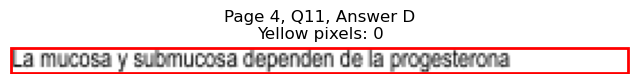


Page 4, Q11 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=122.5, y1=102.2
Page 5, Q1, A: Yellow pixels: 105
Page 5, Q1, A: Total non-white pixels: 743
Page 5, Q1, A: Yellow percentage: 14.1%


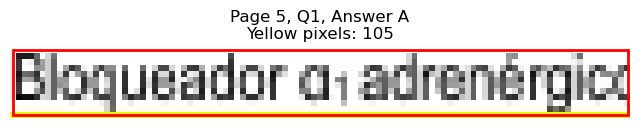

Page 5, Q1 - B: Detected box: x0=114.6, y0=103.8, x1=167.3, y1=114.8
Page 5, Q1, B: Yellow pixels: 1044
Page 5, Q1, B: Total non-white pixels: 1248
Page 5, Q1, B: Yellow percentage: 83.7%


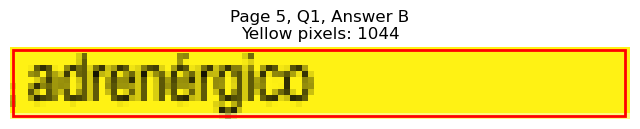

Page 5, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=431.8, y1=102.2
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 526
Page 5, Q1, C: Yellow percentage: 0.0%


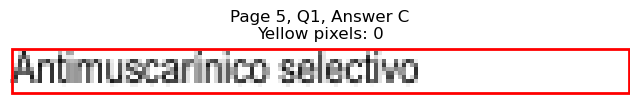

Page 5, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=429.2, y1=114.8
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 525
Page 5, Q1, D: Yellow percentage: 0.0%


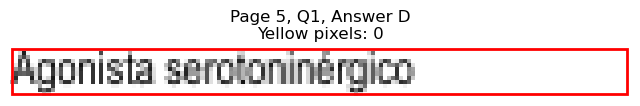


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=206.6, y1=165.3
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 683
Page 5, Q2, A: Yellow percentage: 0.0%


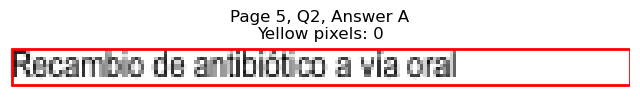

Page 5, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=199.7, y1=177.9
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 687
Page 5, Q2, B: Yellow percentage: 0.0%


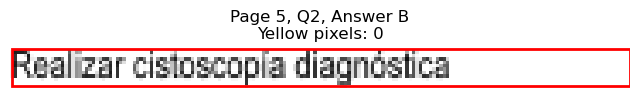

Page 5, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=450.4, y1=165.3
Page 5, Q2, C: Yellow pixels: 174
Page 5, Q2, C: Total non-white pixels: 803
Page 5, Q2, C: Yellow percentage: 21.7%


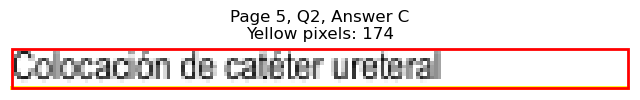

Page 5, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=434.3, y1=177.9
Page 5, Q2, D: Yellow pixels: 1508
Page 5, Q2, D: Total non-white pixels: 1896
Page 5, Q2, D: Yellow percentage: 79.5%


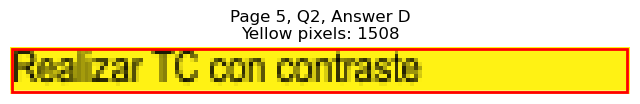


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=152.0, y1=215.7
Page 5, Q3, A: Yellow pixels: 1308
Page 5, Q3, A: Total non-white pixels: 1620
Page 5, Q3, A: Yellow percentage: 80.7%


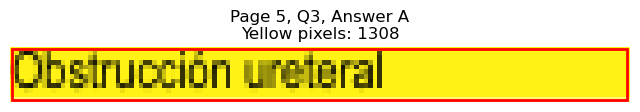

Page 5, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=167.6, y1=228.4
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 519
Page 5, Q3, B: Yellow percentage: 0.0%


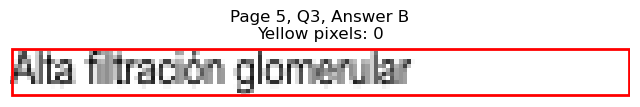

Page 5, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=410.3, y1=215.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 432
Page 5, Q3, C: Yellow percentage: 0.0%


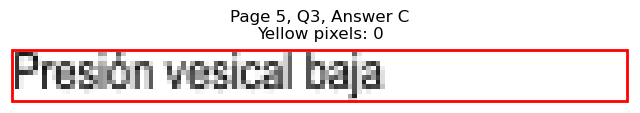

Page 5, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=417.2, y1=228.4
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 435
Page 5, Q3, D: Yellow percentage: 0.0%


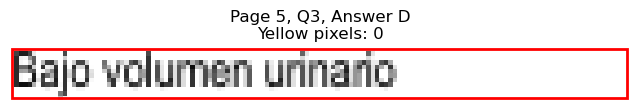


Page 5, Q3 - Selected Answer: A (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=104.4, y1=266.2
Page 5, Q4, A: Yellow pixels: 832
Page 5, Q4, A: Total non-white pixels: 957
Page 5, Q4, A: Yellow percentage: 86.9%


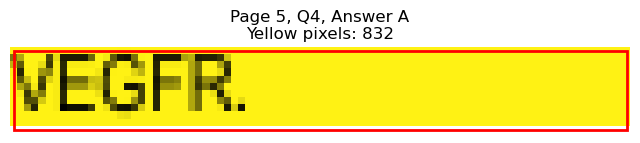

Page 5, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=104.9, y1=278.8
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 184
Page 5, Q4, B: Yellow percentage: 0.0%


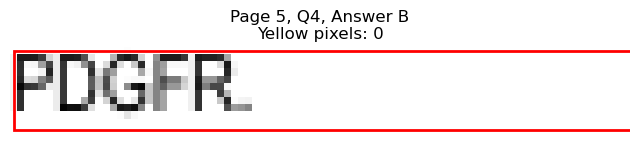

Page 5, Q4 - C: Detected box: x0=327.5, y0=255.2, x1=357.6, y1=266.2
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 138
Page 5, Q4, C: Yellow percentage: 0.0%


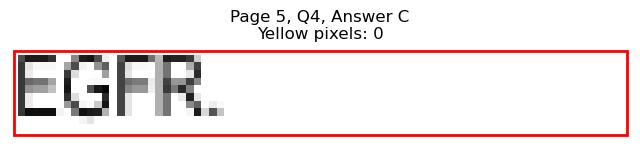

Page 5, Q4 - D: Detected box: x0=327.5, y0=267.8, x1=357.1, y1=278.8
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 139
Page 5, Q4, D: Yellow percentage: 0.0%


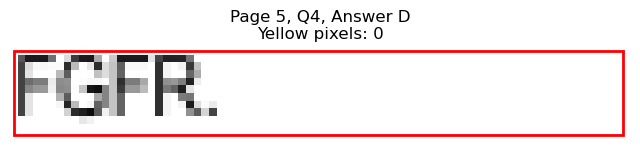


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=143.0, y1=354.7
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 390
Page 5, Q5, A: Yellow percentage: 0.0%


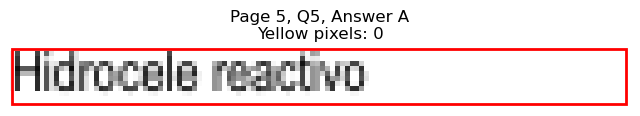

Page 5, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=138.0, y1=367.3
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 338
Page 5, Q5, B: Yellow percentage: 0.0%


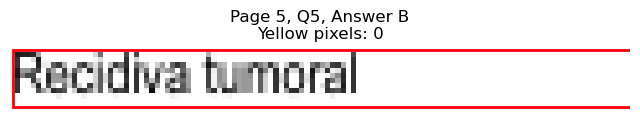

Page 5, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=447.8, y1=354.7
Page 5, Q5, C: Yellow pixels: 1631
Page 5, Q5, C: Total non-white pixels: 2052
Page 5, Q5, C: Yellow percentage: 79.5%


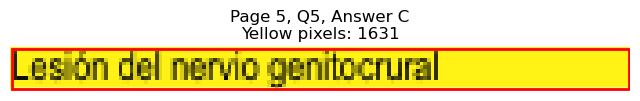

Page 5, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=435.4, y1=367.3
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 535
Page 5, Q5, D: Yellow percentage: 0.0%


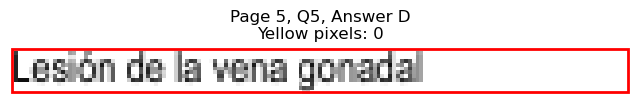


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=289.9, y1=405.1
Page 5, Q6, A: Yellow pixels: 272
Page 5, Q6, A: Total non-white pixels: 1572
Page 5, Q6, A: Yellow percentage: 17.3%


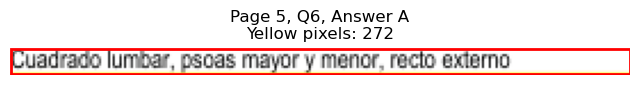

Page 5, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=283.4, y1=417.7
Page 5, Q6, B: Yellow pixels: 2364
Page 5, Q6, B: Total non-white pixels: 3192
Page 5, Q6, B: Yellow percentage: 74.1%


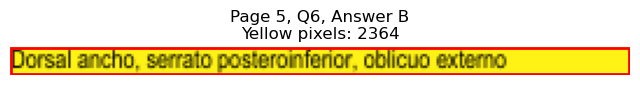

Page 5, Q6 - C: Detected box: x0=68.8, y0=419.4, x1=277.3, y1=430.4
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 1024
Page 5, Q6, C: Yellow percentage: 0.0%


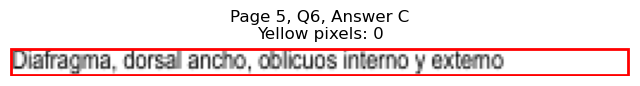

Page 5, Q6 - D: Detected box: x0=68.8, y0=432.0, x1=278.4, y1=443.0
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 1009
Page 5, Q6, D: Yellow percentage: 0.0%


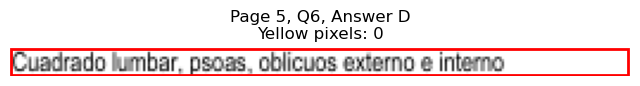


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=133.4, y1=518.7
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 333
Page 5, Q7, A: Yellow percentage: 0.0%


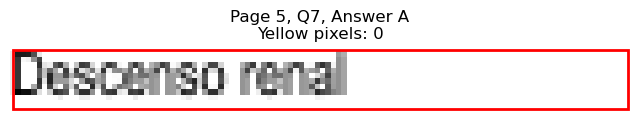

Page 5, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=178.1, y1=531.3
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 561
Page 5, Q7, B: Yellow percentage: 0.0%


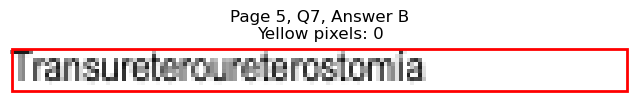

Page 5, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=460.9, y1=518.7
Page 5, Q7, C: Yellow pixels: 184
Page 5, Q7, C: Total non-white pixels: 869
Page 5, Q7, C: Yellow percentage: 21.2%


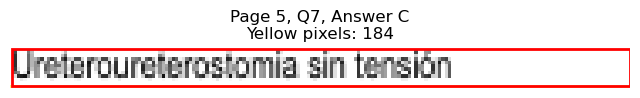

Page 5, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=396.7, y1=531.3
Page 5, Q7, D: Yellow pixels: 1043
Page 5, Q7, D: Total non-white pixels: 1440
Page 5, Q7, D: Yellow percentage: 72.4%


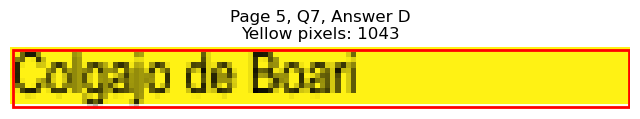


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=570.8, x1=145.0, y1=581.8
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 332
Page 5, Q8, A: Yellow percentage: 0.0%


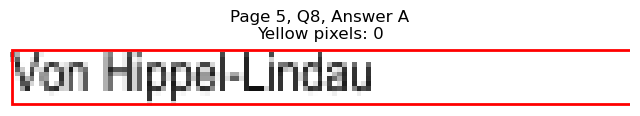

Page 5, Q8 - B: Detected box: x0=68.3, y0=583.4, x1=103.9, y1=594.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 175
Page 5, Q8, B: Yellow percentage: 0.0%


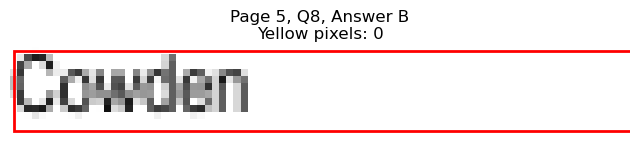

Page 5, Q8 - C: Detected box: x0=327.5, y0=570.8, x1=381.6, y1=581.8
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 385
Page 5, Q8, C: Yellow percentage: 0.0%


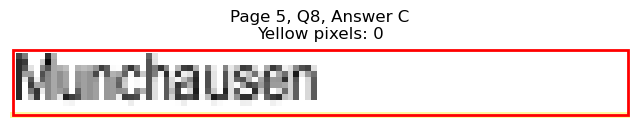

Page 5, Q8 - D: Detected box: x0=327.5, y0=583.4, x1=392.6, y1=594.4
Page 5, Q8, D: Yellow pixels: 1015
Page 5, Q8, D: Total non-white pixels: 1392
Page 5, Q8, D: Yellow percentage: 72.9%


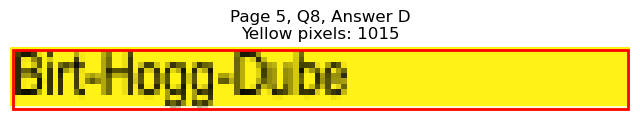


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=621.3, x1=99.4, y1=632.4
Page 5, Q9, A: Yellow pixels: 787
Page 5, Q9, A: Total non-white pixels: 984
Page 5, Q9, A: Yellow percentage: 80.0%


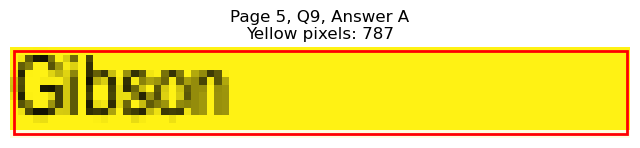

Page 5, Q9 - B: Detected box: x0=68.3, y0=633.9, x1=104.9, y1=645.0
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 165
Page 5, Q9, B: Yellow percentage: 0.0%


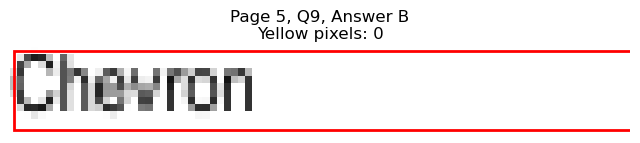

Page 5, Q9 - C: Detected box: x0=327.5, y0=621.3, x1=379.7, y1=632.4
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 289
Page 5, Q9, C: Yellow percentage: 0.0%


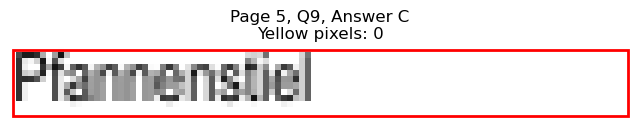

Page 5, Q9 - D: Detected box: x0=327.5, y0=633.9, x1=352.1, y1=645.0
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 124
Page 5, Q9, D: Yellow percentage: 0.0%


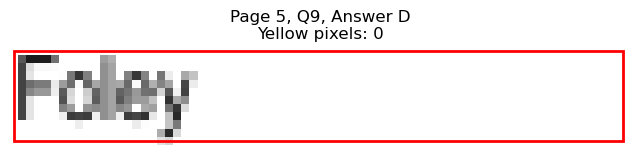


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=124.0, y1=695.4
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 291
Page 5, Q10, A: Yellow percentage: 0.0%


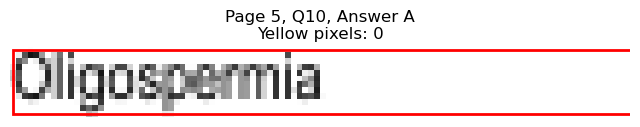

Page 5, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=99.8, y1=708.1
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 152
Page 5, Q10, B: Yellow percentage: 0.0%


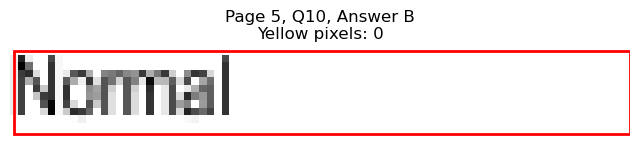

Page 5, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=382.7, y1=695.4
Page 5, Q10, C: Yellow pixels: 960
Page 5, Q10, C: Total non-white pixels: 1272
Page 5, Q10, C: Yellow percentage: 75.5%


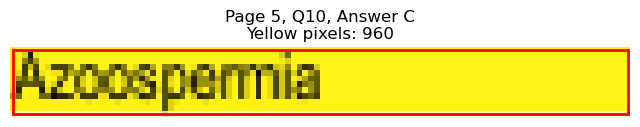

Page 5, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=388.2, y1=708.1
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 323
Page 5, Q10, D: Yellow percentage: 0.0%


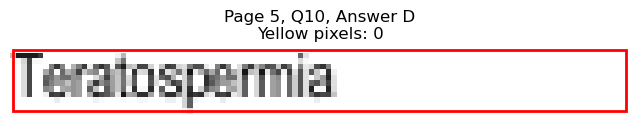


Page 5, Q10 - Selected Answer: C (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=133.0, y1=745.9
Page 5, Q11, A: Yellow pixels: 4
Page 5, Q11, A: Total non-white pixels: 429
Page 5, Q11, A: Yellow percentage: 0.9%


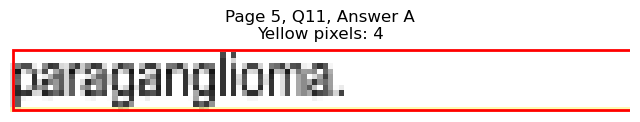

Page 5, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=137.5, y1=758.5
Page 5, Q11, B: Yellow pixels: 1071
Page 5, Q11, B: Total non-white pixels: 1440
Page 5, Q11, B: Yellow percentage: 74.4%


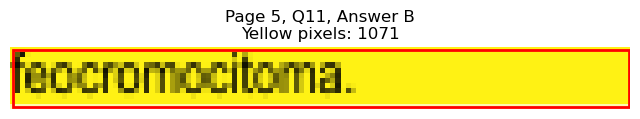

Page 5, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=401.8, y1=745.9
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 375
Page 5, Q11, C: Yellow percentage: 0.0%


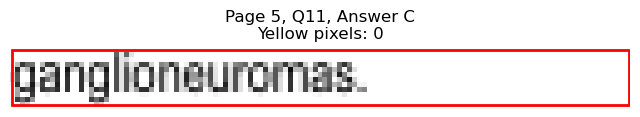

Page 5, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=383.3, y1=758.5
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 276
Page 5, Q11, D: Yellow percentage: 0.0%


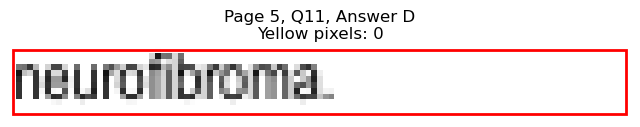


Page 5, Q11 - Selected Answer: B (based on yellow pixel count)





Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=132.5, y1=102.2
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 328
Page 6, Q1, A: Yellow percentage: 0.0%


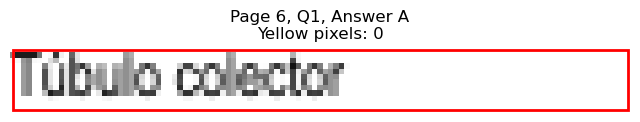

Page 6, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=124.9, y1=114.8
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 261
Page 6, Q1, B: Yellow percentage: 0.0%


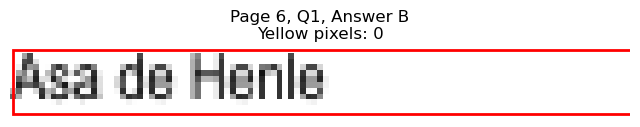

Page 6, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=446.9, y1=102.2
Page 6, Q1, C: Yellow pixels: 1424
Page 6, Q1, C: Total non-white pixels: 1872
Page 6, Q1, C: Yellow percentage: 76.1%


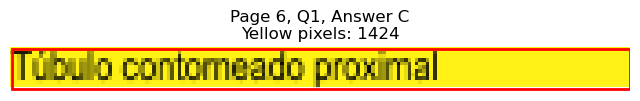

Page 6, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=433.8, y1=114.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 545
Page 6, Q1, D: Yellow percentage: 0.0%


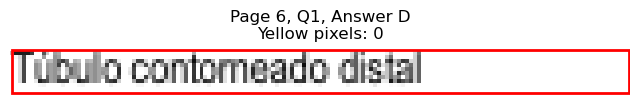


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=207.7, y1=152.7
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 733
Page 6, Q2, A: Yellow percentage: 0.0%


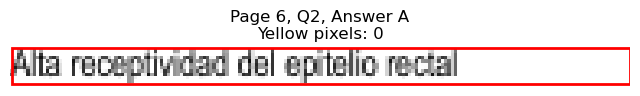

Page 6, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=282.4, y1=165.3
Page 6, Q2, B: Yellow pixels: 159
Page 6, Q2, B: Total non-white pixels: 1337
Page 6, Q2, B: Yellow percentage: 11.9%


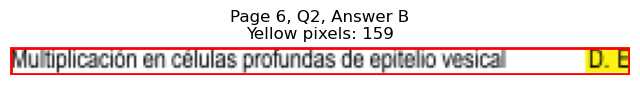

Page 6, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=531.6, y1=152.7
Page 6, Q2, C: Yellow pixels: 213
Page 6, Q2, C: Total non-white pixels: 1238
Page 6, Q2, C: Yellow percentage: 17.2%


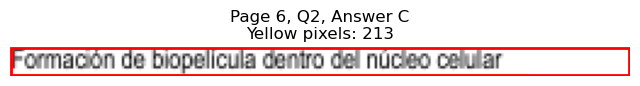

Page 6, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=469.4, y1=165.3
Page 6, Q2, D: Yellow pixels: 1598
Page 6, Q2, D: Total non-white pixels: 2316
Page 6, Q2, D: Yellow percentage: 69.0%


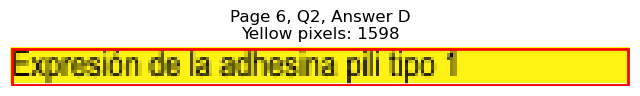


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=192.1, x1=158.0, y1=203.1
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 454
Page 6, Q3, A: Yellow percentage: 0.0%


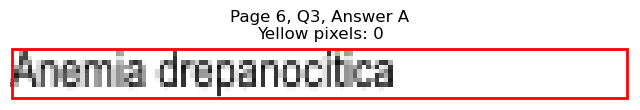

Page 6, Q3 - B: Detected box: x0=68.3, y0=204.7, x1=133.4, y1=215.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 311
Page 6, Q3, B: Yellow percentage: 0.0%


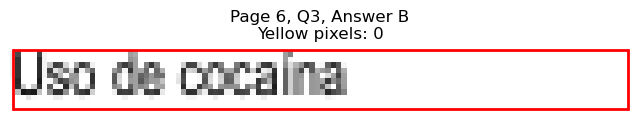

Page 6, Q3 - C: Detected box: x0=327.5, y0=192.1, x1=430.3, y1=203.1
Page 6, Q3, C: Yellow pixels: 154
Page 6, Q3, C: Total non-white pixels: 852
Page 6, Q3, C: Yellow percentage: 18.1%


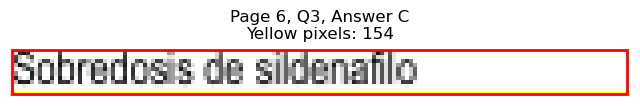

Page 6, Q3 - D: Detected box: x0=327.5, y0=204.7, x1=401.2, y1=215.7
Page 6, Q3, D: Yellow pixels: 1238
Page 6, Q3, D: Total non-white pixels: 1500
Page 6, Q3, D: Yellow percentage: 82.5%


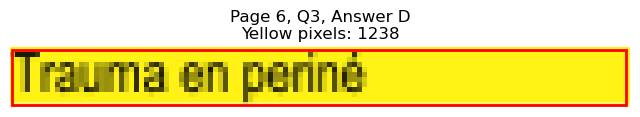


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=242.6, x1=147.6, y1=253.6
Page 6, Q4, A: Yellow pixels: 1138
Page 6, Q4, A: Total non-white pixels: 1560
Page 6, Q4, A: Yellow percentage: 72.9%


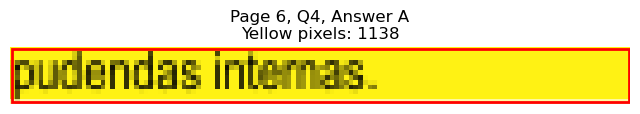

Page 6, Q4 - B: Detected box: x0=68.3, y0=255.2, x1=107.4, y1=266.2
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 198
Page 6, Q4, B: Yellow percentage: 0.0%


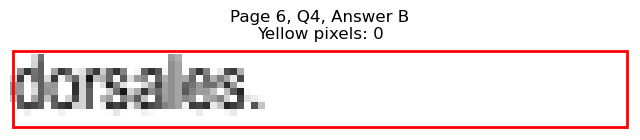

Page 6, Q4 - C: Detected box: x0=327.5, y0=242.6, x1=388.7, y1=253.6
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 314
Page 6, Q4, C: Yellow percentage: 0.0%


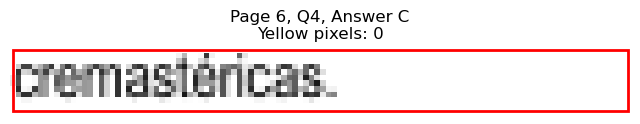

Page 6, Q4 - D: Detected box: x0=327.5, y0=255.2, x1=394.7, y1=266.2
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 327
Page 6, Q4, D: Yellow percentage: 0.0%


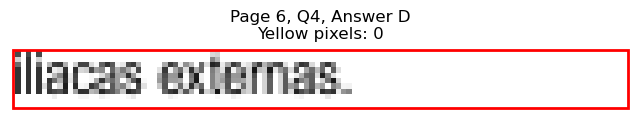


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=293.1, x1=142.0, y1=304.2
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 390
Page 6, Q5, A: Yellow percentage: 0.0%


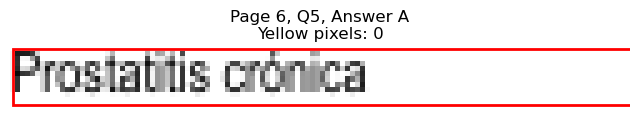

Page 6, Q5 - B: Detected box: x0=68.3, y0=305.7, x1=138.0, y1=316.8
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 356
Page 6, Q5, B: Yellow percentage: 0.0%


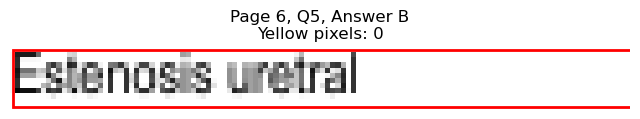

Page 6, Q5 - C: Detected box: x0=327.5, y0=293.1, x1=424.3, y1=304.2
Page 6, Q5, C: Yellow pixels: 1260
Page 6, Q5, C: Total non-white pixels: 1633
Page 6, Q5, C: Yellow percentage: 77.2%


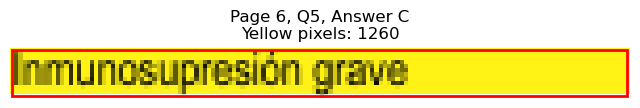

Page 6, Q5 - D: Detected box: x0=327.5, y0=305.7, x1=419.8, y1=316.8
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 465
Page 6, Q5, D: Yellow percentage: 0.0%


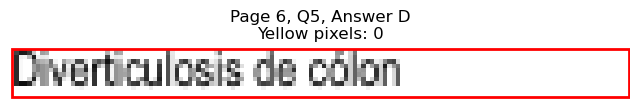


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=343.6, x1=210.7, y1=354.7
Page 6, Q6, A: Yellow pixels: 1803
Page 6, Q6, A: Total non-white pixels: 2316
Page 6, Q6, A: Yellow percentage: 77.8%


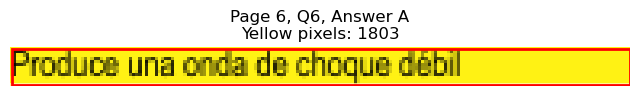

Page 6, Q6 - B: Detected box: x0=68.3, y0=356.2, x1=195.1, y1=367.3
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 614
Page 6, Q6, B: Yellow percentage: 0.0%


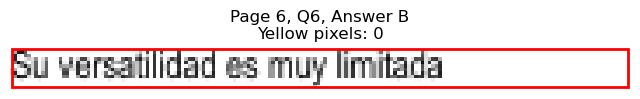

Page 6, Q6 - C: Detected box: x0=327.5, y0=343.6, x1=469.4, y1=354.7
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 692
Page 6, Q6, C: Yellow percentage: 0.0%


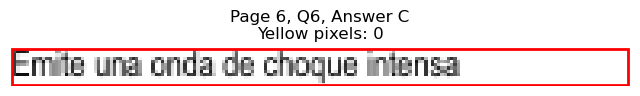

Page 6, Q6 - D: Detected box: x0=327.5, y0=356.2, x1=482.4, y1=367.3
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 809
Page 6, Q6, D: Yellow percentage: 0.0%


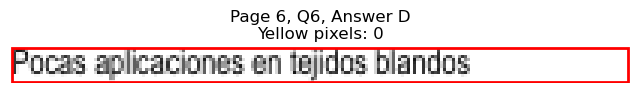


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=394.0, x1=275.9, y1=405.1
Page 6, Q7, A: Yellow pixels: 258
Page 6, Q7, A: Total non-white pixels: 1567
Page 6, Q7, A: Yellow percentage: 16.5%


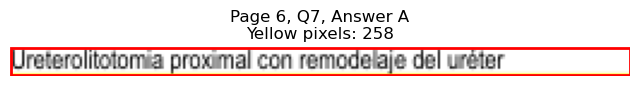

Page 6, Q7 - B: Detected box: x0=68.3, y0=406.6, x1=319.6, y1=417.7
Page 6, Q7, B: Yellow pixels: 2688
Page 6, Q7, B: Total non-white pixels: 3624
Page 6, Q7, B: Yellow percentage: 74.2%


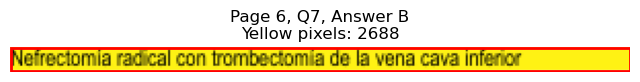

Page 6, Q7 - C: Detected box: x0=68.8, y0=419.4, x1=249.7, y1=430.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 898
Page 6, Q7, C: Yellow percentage: 0.0%


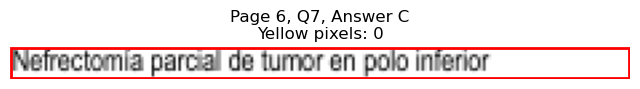

Page 6, Q7 - D: Detected box: x0=68.8, y0=432.0, x1=264.4, y1=443.0
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 985
Page 6, Q7, D: Yellow percentage: 0.0%


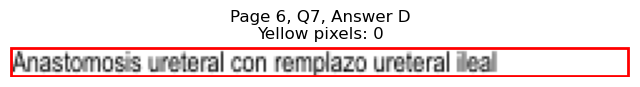


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=482.5, x1=93.4, y1=493.5
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 135
Page 6, Q8, A: Yellow percentage: 0.0%


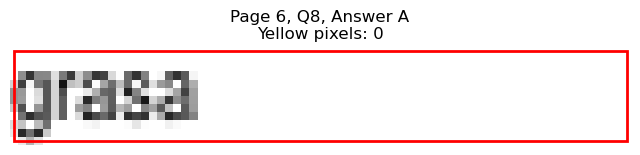

Page 6, Q8 - B: Detected box: x0=68.3, y0=495.1, x1=99.4, y1=506.1
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 160
Page 6, Q8, B: Yellow percentage: 0.0%


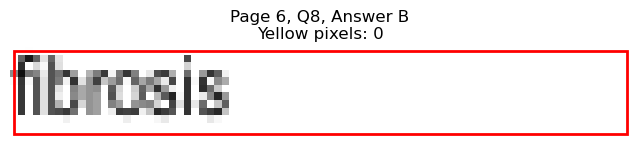

Page 6, Q8 - C: Detected box: x0=327.5, y0=482.5, x1=366.6, y1=493.5
Page 6, Q8, C: Yellow pixels: 818
Page 6, Q8, C: Total non-white pixels: 1080
Page 6, Q8, C: Yellow percentage: 75.7%


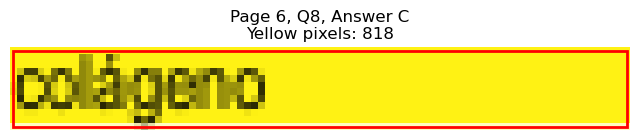

Page 6, Q8 - D: Detected box: x0=327.5, y0=495.1, x1=370.7, y1=506.1
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 211
Page 6, Q8, D: Yellow percentage: 0.0%


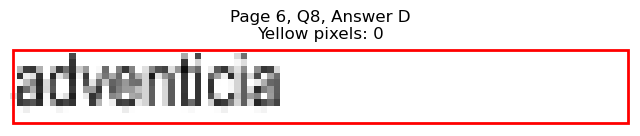


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=545.5, x1=162.6, y1=556.5
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 482
Page 6, Q9, A: Yellow percentage: 0.0%


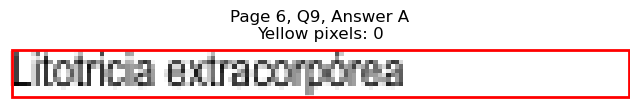

Page 6, Q9 - B: Detected box: x0=68.3, y0=558.2, x1=162.0, y1=569.2
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 488
Page 6, Q9, B: Yellow percentage: 0.0%


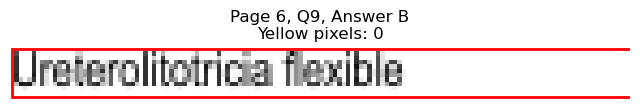

Page 6, Q9 - C: Detected box: x0=327.5, y0=545.5, x1=442.3, y1=556.5
Page 6, Q9, C: Yellow pixels: 166
Page 6, Q9, C: Total non-white pixels: 758
Page 6, Q9, C: Yellow percentage: 21.9%


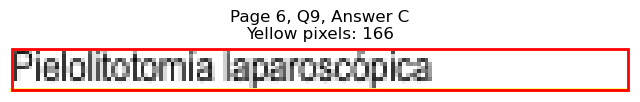

Page 6, Q9 - D: Detected box: x0=327.5, y0=558.2, x1=430.3, y1=569.2
Page 6, Q9, D: Yellow pixels: 1285
Page 6, Q9, D: Total non-white pixels: 1696
Page 6, Q9, D: Yellow percentage: 75.8%


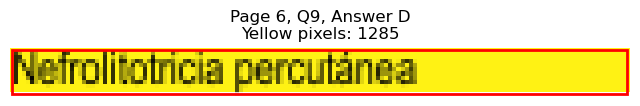


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=608.6, x1=160.1, y1=619.6
Page 6, Q10, A: Yellow pixels: 1352
Page 6, Q10, A: Total non-white pixels: 1716
Page 6, Q10, A: Yellow percentage: 78.8%


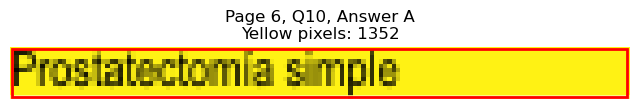

Page 6, Q10 - B: Detected box: x0=68.3, y0=621.3, x1=190.7, y1=632.4
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 614
Page 6, Q10, B: Yellow percentage: 0.0%


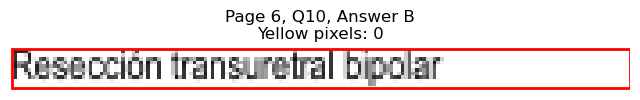

Page 6, Q10 - C: Detected box: x0=327.5, y0=608.6, x1=437.8, y1=619.6
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 557
Page 6, Q10, C: Yellow percentage: 0.0%


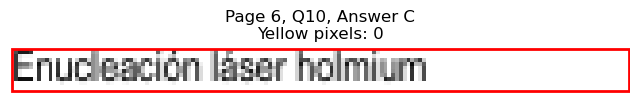

Page 6, Q10 - D: Detected box: x0=327.5, y0=621.3, x1=396.8, y1=632.4
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 355
Page 6, Q10, D: Yellow percentage: 0.0%


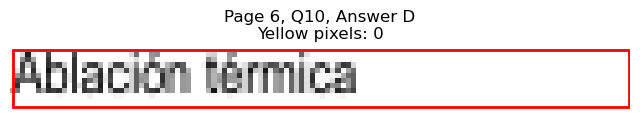


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=659.1, x1=160.6, y1=670.2
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 436
Page 6, Q11, A: Yellow percentage: 0.0%


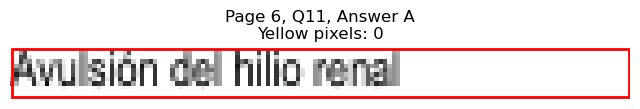

Page 6, Q11 - B: Detected box: x0=68.3, y0=671.7, x1=177.1, y1=682.8
Page 6, Q11, B: Yellow pixels: 160
Page 6, Q11, B: Total non-white pixels: 656
Page 6, Q11, B: Yellow percentage: 24.4%


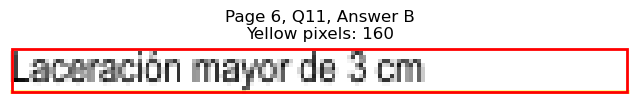

Page 6, Q11 - C: Detected box: x0=68.8, y0=684.3, x1=211.7, y1=695.4
Page 6, Q11, C: Yellow pixels: 1598
Page 6, Q11, C: Total non-white pixels: 2328
Page 6, Q11, C: Yellow percentage: 68.6%


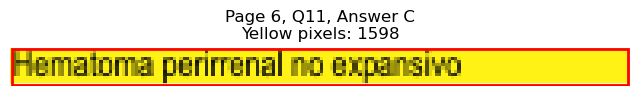

Page 6, Q11 - D: Detected box: x0=68.8, y0=697.0, x1=289.4, y1=708.1
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 1119
Page 6, Q11, D: Yellow percentage: 0.0%


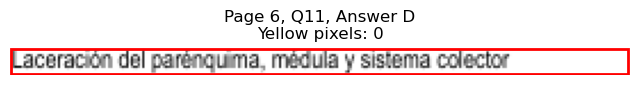


Page 6, Q11 - Selected Answer: C (based on yellow pixel count)




Page 6, Q12 - A: Detected box: x0=68.3, y0=747.4, x1=118.0, y1=758.5
Page 6, Q12, A: Yellow pixels: 0
Page 6, Q12, A: Total non-white pixels: 260
Page 6, Q12, A: Yellow percentage: 0.0%


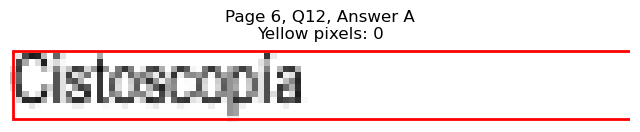

Page 6, Q12 - B: Detected box: x0=68.3, y0=760.2, x1=117.0, y1=771.2
Page 6, Q12, B: Yellow pixels: 0
Page 6, Q12, B: Total non-white pixels: 250
Page 6, Q12, B: Yellow percentage: 0.0%


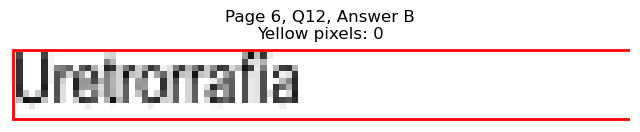

Page 6, Q12 - C: Detected box: x0=327.5, y0=747.4, x1=421.8, y1=758.5
Page 6, Q12, C: Yellow pixels: 1243
Page 6, Q12, C: Total non-white pixels: 1740
Page 6, Q12, C: Yellow percentage: 71.4%


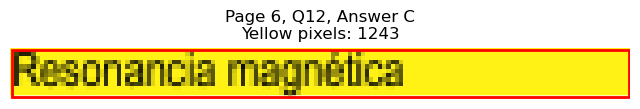

Page 6, Q12 - D: Detected box: x0=327.5, y0=760.2, x1=399.2, y1=771.2
Page 6, Q12, D: Yellow pixels: 0
Page 6, Q12, D: Total non-white pixels: 386
Page 6, Q12, D: Yellow percentage: 0.0%


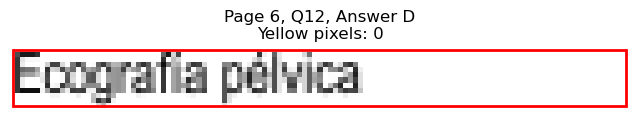


Page 6, Q12 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=210.7, y1=114.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 737
Page 7, Q1, A: Yellow percentage: 0.0%


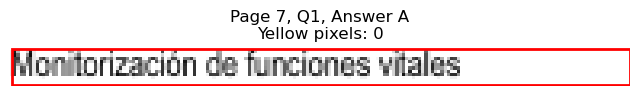

Page 7, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=198.7, y1=127.4
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 644
Page 7, Q1, B: Yellow percentage: 0.0%


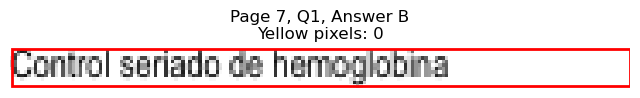

Page 7, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=431.3, y1=114.8
Page 7, Q1, C: Yellow pixels: 1451
Page 7, Q1, C: Total non-white pixels: 1860
Page 7, Q1, C: Yellow percentage: 78.0%


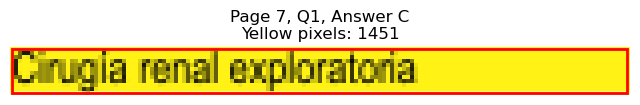

Page 7, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=409.2, y1=127.4
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 427
Page 7, Q1, D: Yellow percentage: 0.0%


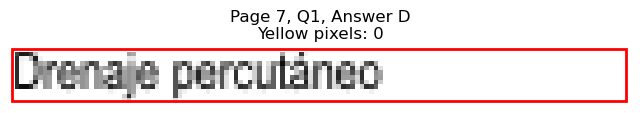


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=85.8, y1=177.9
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 64
Page 7, Q2, A: Yellow percentage: 0.0%


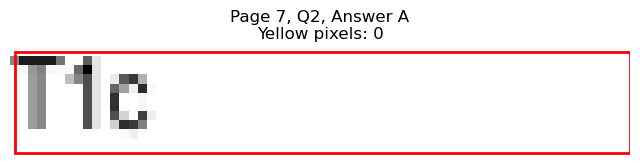

Page 7, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=86.4, y1=190.5
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 78
Page 7, Q2, B: Yellow percentage: 0.0%


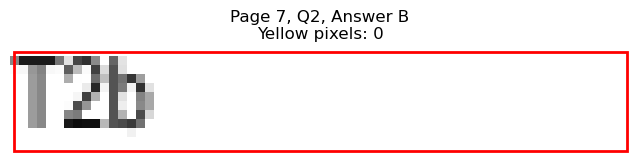

Page 7, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=345.6, y1=177.9
Page 7, Q2, C: Yellow pixels: 768
Page 7, Q2, C: Total non-white pixels: 828
Page 7, Q2, C: Yellow percentage: 92.8%


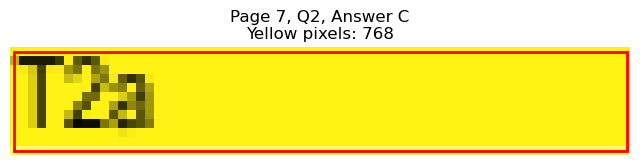

Page 7, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=345.6, y1=190.5
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 73
Page 7, Q2, D: Yellow percentage: 0.0%


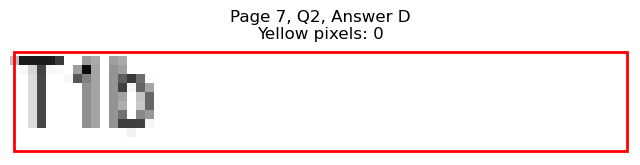


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=180.1, y1=228.4
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 538
Page 7, Q3, A: Yellow percentage: 0.0%


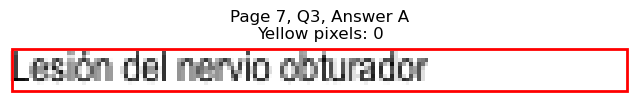

Page 7, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=121.9, y1=241.0
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 261
Page 7, Q3, B: Yellow percentage: 0.0%


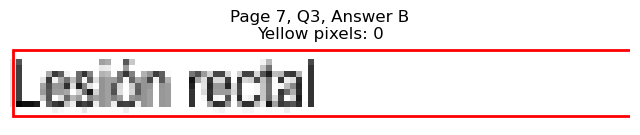

Page 7, Q3 - C: Detected box: x0=327.5, y0=532.9, x1=377.3, y1=543.9
Page 7, Q3, C: Yellow pixels: 840
Page 7, Q3, C: Total non-white pixels: 1212
Page 7, Q3, C: Yellow percentage: 69.3%


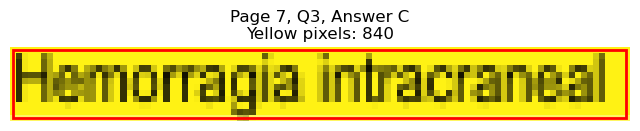

Page 7, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=370.1, y1=241.0
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 223
Page 7, Q3, D: Yellow percentage: 0.0%


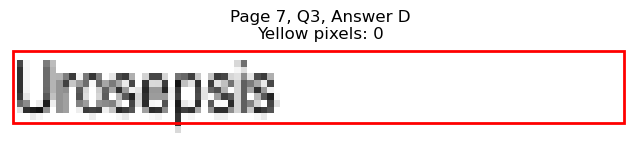


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=118.9, y1=278.8
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 257
Page 7, Q4, A: Yellow percentage: 0.0%


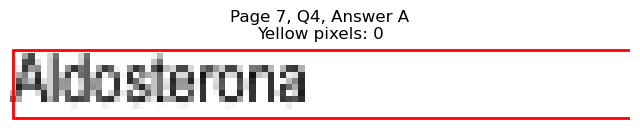

Page 7, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=110.9, y1=291.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 211
Page 7, Q4, B: Yellow percentage: 0.0%


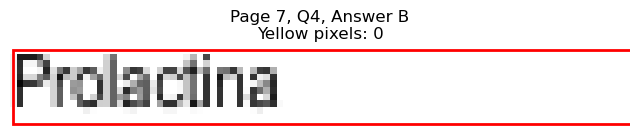

Page 7, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=408.2, y1=278.8
Page 7, Q4, C: Yellow pixels: 1244
Page 7, Q4, C: Total non-white pixels: 1584
Page 7, Q4, C: Yellow percentage: 78.5%


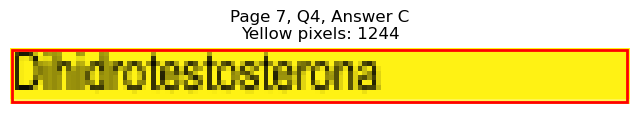

Page 7, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=384.1, y1=291.6
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 287
Page 7, Q4, D: Yellow percentage: 0.0%


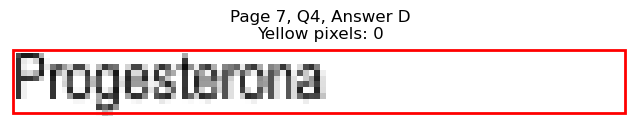


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=106.9, y1=342.0
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 187
Page 7, Q5, A: Yellow percentage: 0.0%


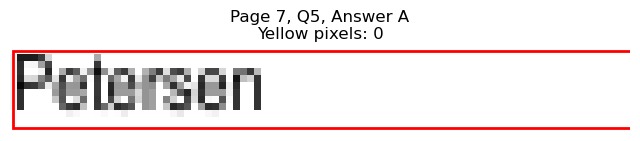

Page 7, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=102.8, y1=354.7
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 174
Page 7, Q5, B: Yellow percentage: 0.0%


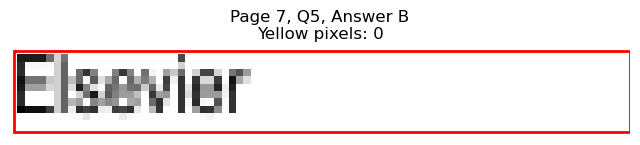

Page 7, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=368.2, y1=342.0
Page 7, Q5, C: Yellow pixels: 922
Page 7, Q5, C: Total non-white pixels: 1104
Page 7, Q5, C: Yellow percentage: 83.5%


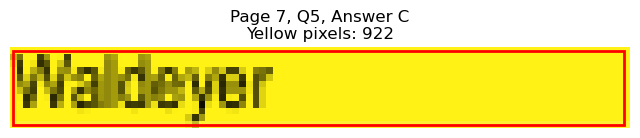

Page 7, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=355.1, y1=354.7
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 127
Page 7, Q5, D: Yellow percentage: 0.0%


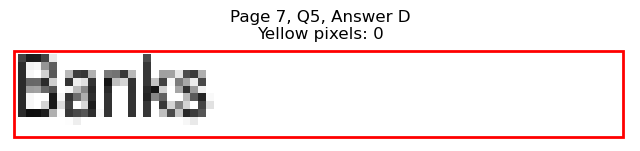


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=406.6, x1=155.0, y1=417.7
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 419
Page 7, Q6, A: Yellow percentage: 0.0%


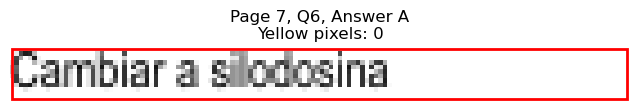

Page 7, Q6 - B: Detected box: x0=68.3, y0=419.4, x1=147.5, y1=430.4
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 401
Page 7, Q6, B: Yellow percentage: 0.0%


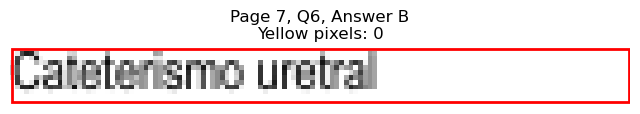

Page 7, Q6 - C: Detected box: x0=327.5, y0=406.6, x1=426.7, y1=417.7
Page 7, Q6, C: Yellow pixels: 150
Page 7, Q6, C: Total non-white pixels: 672
Page 7, Q6, C: Yellow percentage: 22.3%


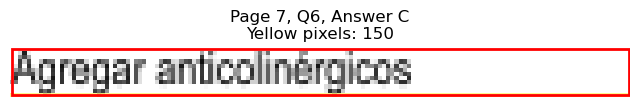

Page 7, Q6 - D: Detected box: x0=327.5, y0=419.4, x1=396.2, y1=430.4
Page 7, Q6, D: Yellow pixels: 1058
Page 7, Q6, D: Total non-white pixels: 1440
Page 7, Q6, D: Yellow percentage: 73.5%


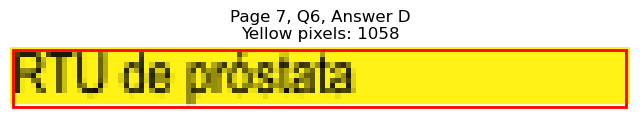


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=457.2, x1=150.5, y1=468.2
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 387
Page 7, Q7, A: Yellow percentage: 0.0%


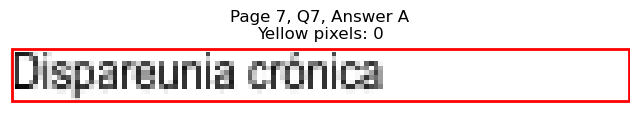

Page 7, Q7 - B: Detected box: x0=68.3, y0=469.8, x1=138.0, y1=480.8
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 323
Page 7, Q7, B: Yellow percentage: 0.0%


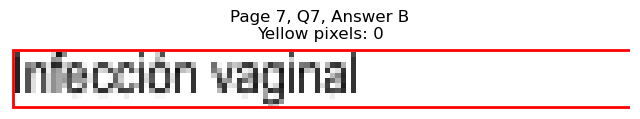

Page 7, Q7 - C: Detected box: x0=327.5, y0=457.2, x1=427.3, y1=468.2
Page 7, Q7, C: Yellow pixels: 1297
Page 7, Q7, C: Total non-white pixels: 1661
Page 7, Q7, C: Yellow percentage: 78.1%


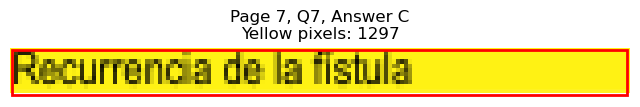

Page 7, Q7 - D: Detected box: x0=327.5, y0=469.8, x1=408.7, y1=480.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 436
Page 7, Q7, D: Yellow percentage: 0.0%


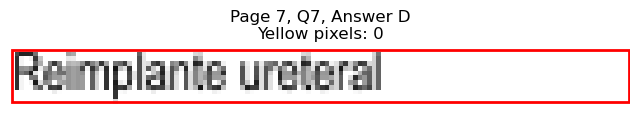


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=532.9, x1=195.2, y1=543.9
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 596
Page 7, Q8, A: Yellow percentage: 0.0%


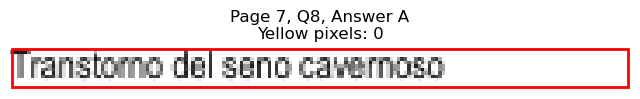

Page 7, Q8 - B: Detected box: x0=68.3, y0=545.5, x1=204.7, y1=556.5
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 692
Page 7, Q8, B: Yellow percentage: 0.0%


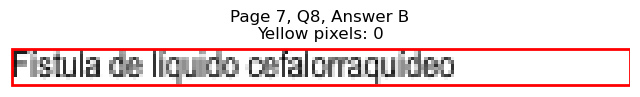

Page 7, Q8 - C: Detected box: x0=327.5, y0=532.9, x1=426.7, y1=543.9
Page 7, Q8, C: Yellow pixels: 1428
Page 7, Q8, C: Total non-white pixels: 1800
Page 7, Q8, C: Yellow percentage: 79.3%


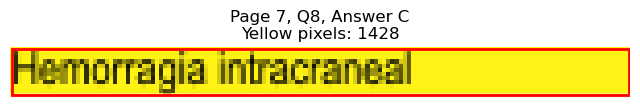

Page 7, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=417.2, y1=556.5
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 466
Page 7, Q8, D: Yellow percentage: 0.0%


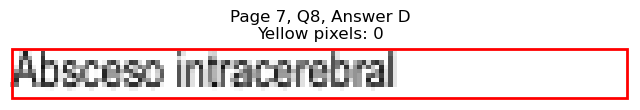


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=121.9, y1=619.6
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 287
Page 7, Q9, A: Yellow percentage: 0.0%


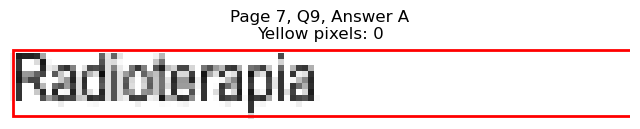

Page 7, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=154.1, y1=632.4
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 444
Page 7, Q9, B: Yellow percentage: 0.0%


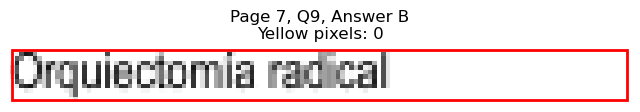

Page 7, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=386.2, y1=619.6
Page 7, Q9, C: Yellow pixels: 1099
Page 7, Q9, C: Total non-white pixels: 1320
Page 7, Q9, C: Yellow percentage: 83.3%


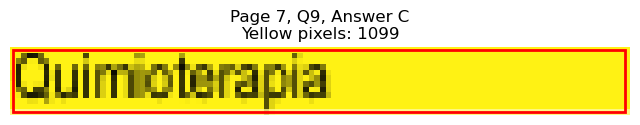

Page 7, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=408.2, y1=632.4
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 409
Page 7, Q9, D: Yellow percentage: 0.0%


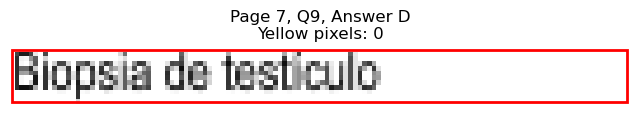


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=671.7, x1=162.6, y1=682.8
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 482
Page 7, Q10, A: Yellow percentage: 0.0%


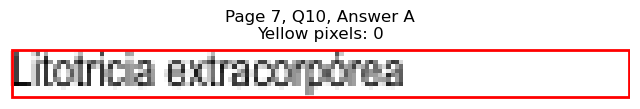

Page 7, Q10 - B: Detected box: x0=68.3, y0=684.3, x1=171.1, y1=695.4
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 539
Page 7, Q10, B: Yellow percentage: 0.0%


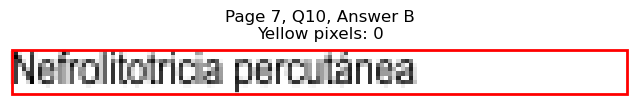

Page 7, Q10 - C: Detected box: x0=327.5, y0=671.7, x1=452.4, y1=682.8
Page 7, Q10, C: Yellow pixels: 176
Page 7, Q10, C: Total non-white pixels: 832
Page 7, Q10, C: Yellow percentage: 21.2%


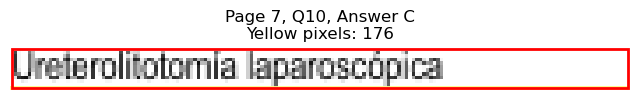

Page 7, Q10 - D: Detected box: x0=327.5, y0=684.3, x1=412.7, y1=695.4
Page 7, Q10, D: Yellow pixels: 1168
Page 7, Q10, D: Total non-white pixels: 1632
Page 7, Q10, D: Yellow percentage: 71.6%


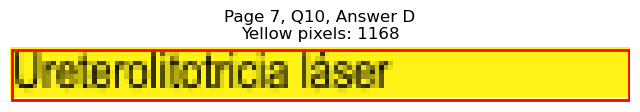


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=722.2, x1=109.9, y1=733.3
Page 7, Q11, A: Yellow pixels: 92
Page 7, Q11, A: Total non-white pixels: 309
Page 7, Q11, A: Yellow percentage: 29.8%


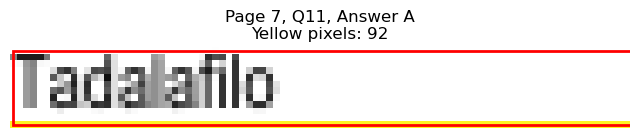

Page 7, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=116.4, y1=745.9
Page 7, Q11, B: Yellow pixels: 994
Page 7, Q11, B: Total non-white pixels: 1188
Page 7, Q11, B: Yellow percentage: 83.7%


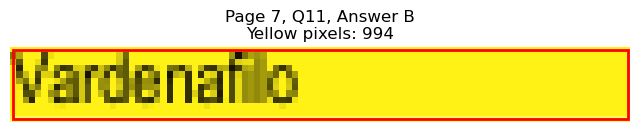

Page 7, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=367.1, y1=733.3
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 196
Page 7, Q11, C: Yellow percentage: 0.0%


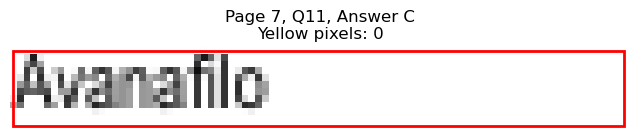

Page 7, Q11 - D: Detected box: x0=327.5, y0=734.8, x1=366.7, y1=745.9
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 219
Page 7, Q11, D: Yellow percentage: 0.0%


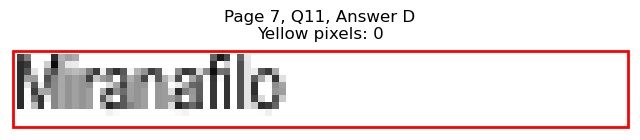


Page 7, Q11 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 12 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=135.0, y1=127.4
Page 8, Q1, A: Yellow pixels: 1008
Page 8, Q1, A: Total non-white pixels: 1404
Page 8, Q1, A: Yellow percentage: 71.8%


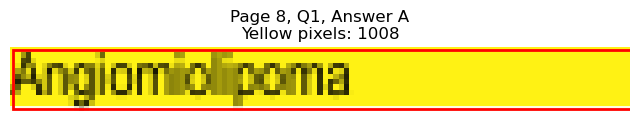

Page 8, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=158.0, y1=140.0
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 449
Page 8, Q1, B: Yellow percentage: 0.0%


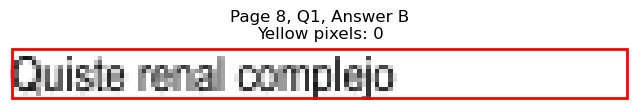

Page 8, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=396.1, y1=127.4
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 322
Page 8, Q1, C: Yellow percentage: 0.0%


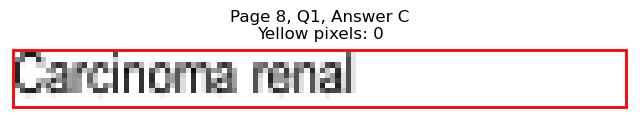

Page 8, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=378.1, y1=140.0
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 243
Page 8, Q1, D: Yellow percentage: 0.0%


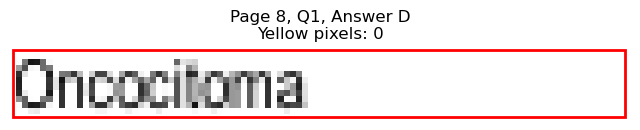


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=198.7, y1=177.9
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 639
Page 8, Q2, A: Yellow percentage: 0.0%


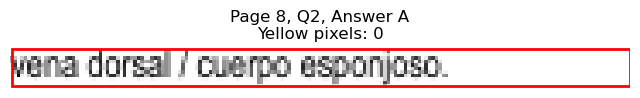

Page 8, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=218.2, y1=190.5
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 761
Page 8, Q2, B: Yellow percentage: 0.0%


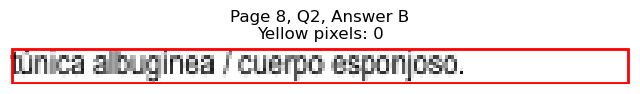

Page 8, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=458.4, y1=177.9
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 791
Page 8, Q2, C: Yellow percentage: 0.0%


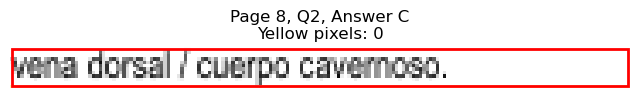

Page 8, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=478.0, y1=190.5
Page 8, Q2, D: Yellow pixels: 1641
Page 8, Q2, D: Total non-white pixels: 2412
Page 8, Q2, D: Yellow percentage: 68.0%


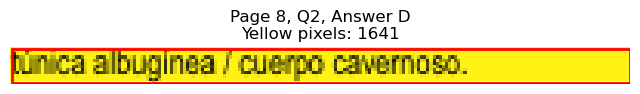


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=139.6, y1=228.4
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 363
Page 8, Q3, A: Yellow percentage: 0.0%


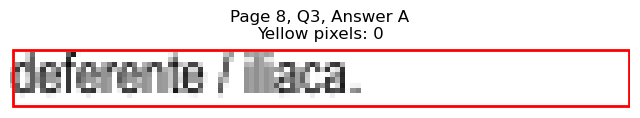

Page 8, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=176.0, y1=241.0
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 530
Page 8, Q3, B: Yellow percentage: 0.0%


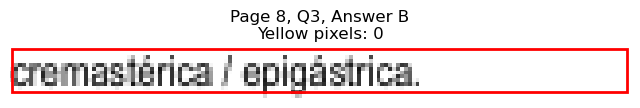

Page 8, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=437.8, y1=228.4
Page 8, Q3, C: Yellow pixels: 161
Page 8, Q3, C: Total non-white pixels: 754
Page 8, Q3, C: Yellow percentage: 21.4%


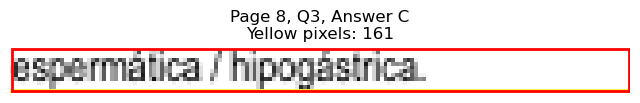

Page 8, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=396.7, y1=241.0
Page 8, Q3, D: Yellow pixels: 1198
Page 8, Q3, D: Total non-white pixels: 1440
Page 8, Q3, D: Yellow percentage: 83.2%


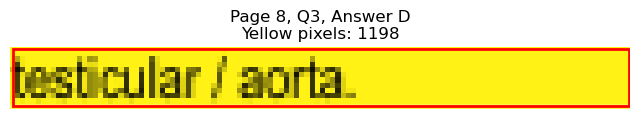


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=118.0, y1=278.8
Page 8, Q4, A: Yellow pixels: 1020
Page 8, Q4, A: Total non-white pixels: 1200
Page 8, Q4, A: Yellow percentage: 85.0%


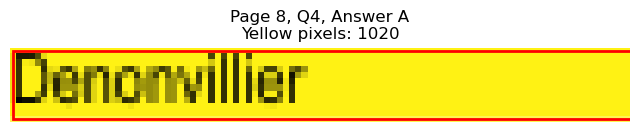

Page 8, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=106.4, y1=291.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 202
Page 8, Q4, B: Yellow percentage: 0.0%


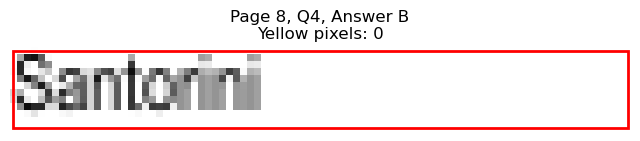

Page 8, Q4 - C: Detected box: x0=327.5, y0=267.8, x1=368.2, y1=278.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 224
Page 8, Q4, C: Yellow percentage: 0.0%


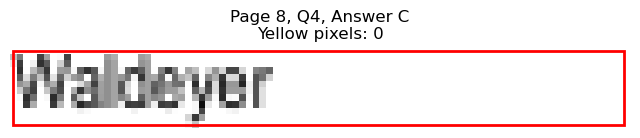

Page 8, Q4 - D: Detected box: x0=327.5, y0=280.5, x1=360.1, y1=291.6
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 174
Page 8, Q4, D: Yellow percentage: 0.0%


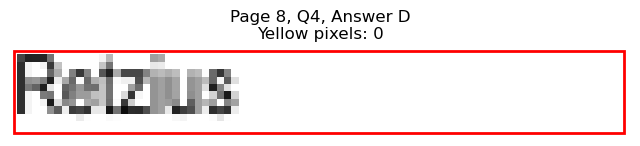


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=330.9, x1=137.5, y1=342.0
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 340
Page 8, Q5, A: Yellow percentage: 0.0%


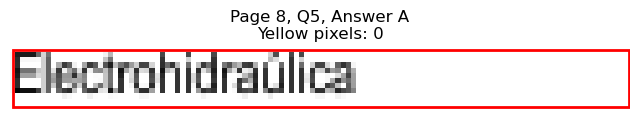

Page 8, Q5 - B: Detected box: x0=68.3, y0=343.6, x1=113.4, y1=354.7
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 248
Page 8, Q5, B: Yellow percentage: 0.0%


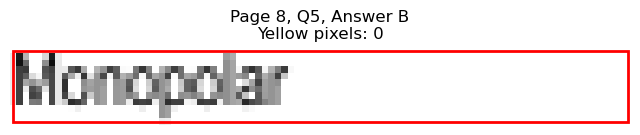

Page 8, Q5 - C: Detected box: x0=327.5, y0=330.9, x1=362.5, y1=342.0
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 245
Page 8, Q5, C: Yellow percentage: 0.0%


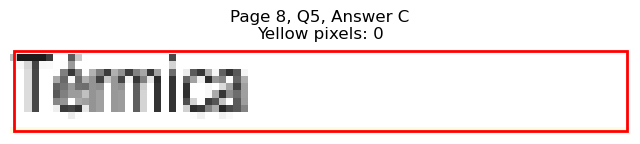

Page 8, Q5 - D: Detected box: x0=327.5, y0=343.6, x1=352.6, y1=354.7
Page 8, Q5, D: Yellow pixels: 826
Page 8, Q5, D: Total non-white pixels: 912
Page 8, Q5, D: Yellow percentage: 90.6%


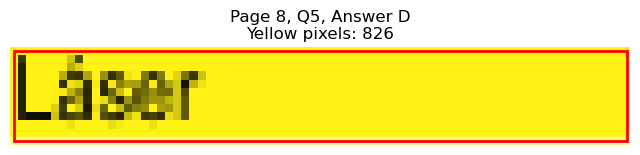


Page 8, Q5 - Selected Answer: D (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=106.9, y1=405.1
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 189
Page 8, Q6, A: Yellow percentage: 0.0%


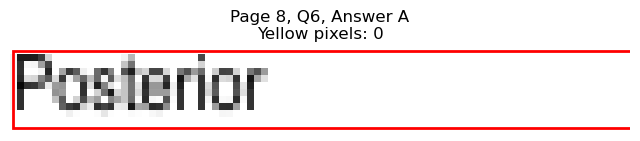

Page 8, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=137.5, y1=417.7
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 356
Page 8, Q6, B: Yellow percentage: 0.0%


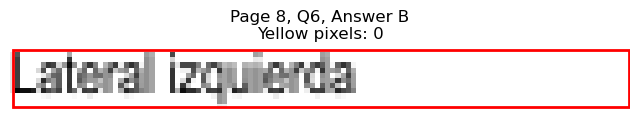

Page 8, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=361.6, y1=405.1
Page 8, Q6, C: Yellow pixels: 804
Page 8, Q6, C: Total non-white pixels: 935
Page 8, Q6, C: Yellow percentage: 86.0%


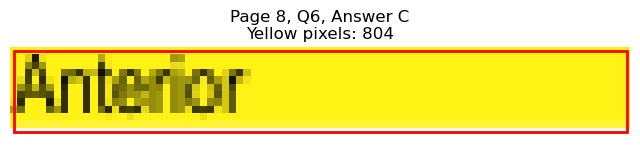

Page 8, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=392.6, y1=417.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 322
Page 8, Q6, D: Yellow percentage: 0.0%


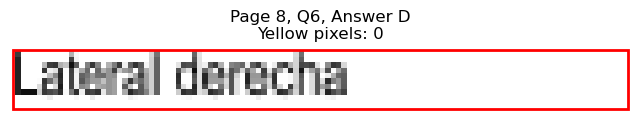


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=444.6, x1=121.4, y1=455.6
Page 8, Q7, A: Yellow pixels: 104
Page 8, Q7, A: Total non-white pixels: 356
Page 8, Q7, A: Yellow percentage: 29.2%


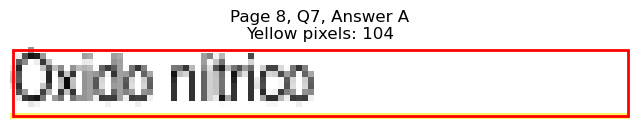

Page 8, Q7 - B: Detected box: x0=68.3, y0=457.2, x1=127.4, y1=468.2
Page 8, Q7, B: Yellow pixels: 953
Page 8, Q7, B: Total non-white pixels: 1210
Page 8, Q7, B: Yellow percentage: 78.8%


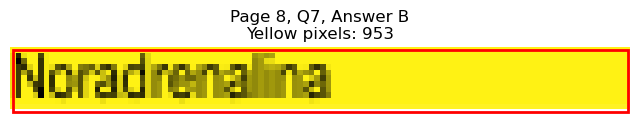

Page 8, Q7 - C: Detected box: x0=327.5, y0=444.6, x1=375.6, y1=455.6
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 260
Page 8, Q7, C: Yellow percentage: 0.0%


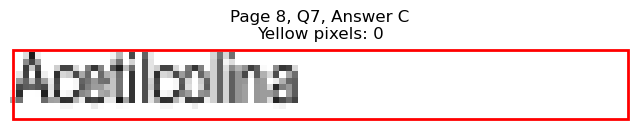

Page 8, Q7 - D: Detected box: x0=327.5, y0=457.2, x1=373.7, y1=468.2
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 242
Page 8, Q7, D: Yellow percentage: 0.0%


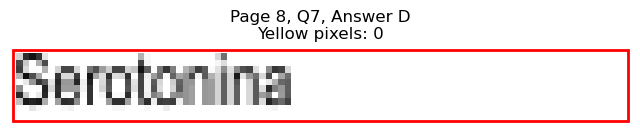


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=507.7, x1=141.0, y1=518.7
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 342
Page 8, Q8, A: Yellow percentage: 0.0%


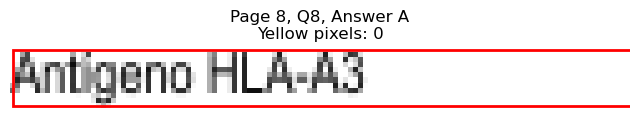

Page 8, Q8 - B: Detected box: x0=68.3, y0=520.3, x1=128.5, y1=531.3
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 279
Page 8, Q8, B: Yellow percentage: 0.0%


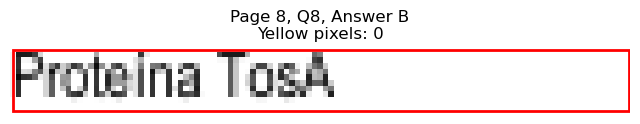

Page 8, Q8 - C: Detected box: x0=327.5, y0=507.7, x1=391.7, y1=518.7
Page 8, Q8, C: Yellow pixels: 115
Page 8, Q8, C: Total non-white pixels: 435
Page 8, Q8, C: Yellow percentage: 26.4%


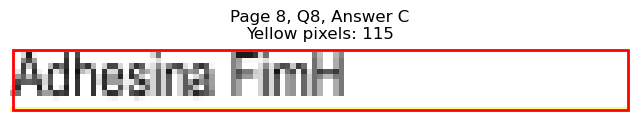

Page 8, Q8 - D: Detected box: x0=327.5, y0=520.3, x1=425.8, y1=531.3
Page 8, Q8, D: Yellow pixels: 1260
Page 8, Q8, D: Total non-white pixels: 1788
Page 8, Q8, D: Yellow percentage: 70.5%


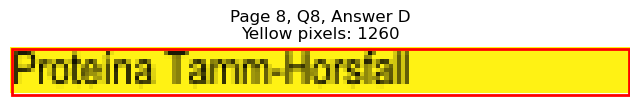


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=558.2, x1=185.2, y1=569.2
Page 8, Q9, A: Yellow pixels: 1432
Page 8, Q9, A: Total non-white pixels: 1848
Page 8, Q9, A: Yellow percentage: 77.5%


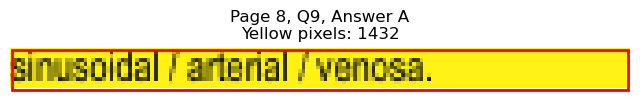

Page 8, Q9 - B: Detected box: x0=68.3, y0=570.8, x1=174.1, y1=581.8
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 492
Page 8, Q9, B: Yellow percentage: 0.0%


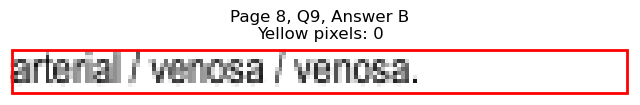

Page 8, Q9 - C: Detected box: x0=327.5, y0=558.2, x1=450.8, y1=569.2
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 612
Page 8, Q9, C: Yellow percentage: 0.0%


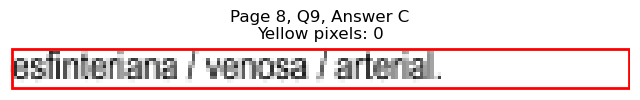

Page 8, Q9 - D: Detected box: x0=327.5, y0=570.8, x1=463.4, y1=581.8
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 666
Page 8, Q9, D: Yellow percentage: 0.0%


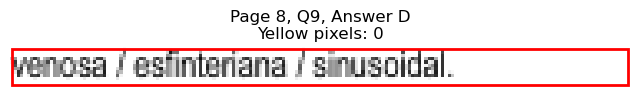


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=608.6, x1=178.6, y1=619.6
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 558
Page 8, Q10, A: Yellow percentage: 0.0%


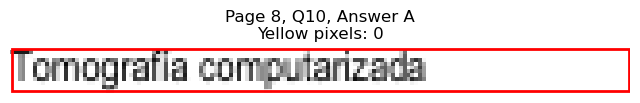

Page 8, Q10 - B: Detected box: x0=68.3, y0=621.3, x1=153.6, y1=632.4
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 453
Page 8, Q10, B: Yellow percentage: 0.0%


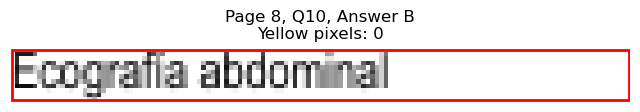

Page 8, Q10 - C: Detected box: x0=327.5, y0=608.6, x1=407.3, y1=619.6
Page 8, Q10, C: Yellow pixels: 1265
Page 8, Q10, C: Total non-white pixels: 1572
Page 8, Q10, C: Yellow percentage: 80.5%


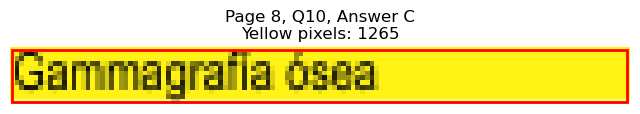

Page 8, Q10 - D: Detected box: x0=327.5, y0=621.3, x1=403.2, y1=632.4
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 391
Page 8, Q10, D: Yellow percentage: 0.0%


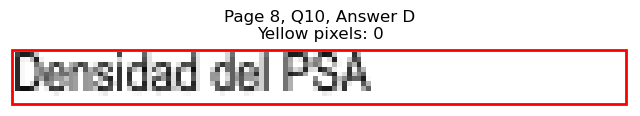


Page 8, Q10 - Selected Answer: C (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=659.1, x1=121.9, y1=670.2
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 281
Page 8, Q11, A: Yellow percentage: 0.0%


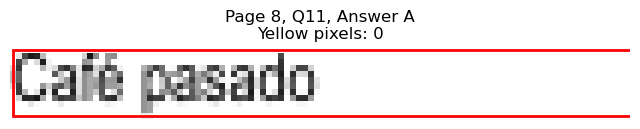

Page 8, Q11 - B: Detected box: x0=68.3, y0=671.7, x1=129.5, y1=682.8
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 300
Page 8, Q11, B: Yellow percentage: 0.0%


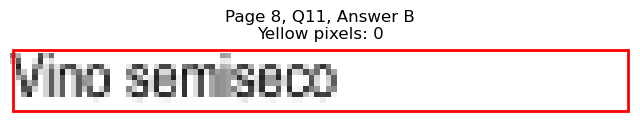

Page 8, Q11 - C: Detected box: x0=327.5, y0=659.1, x1=419.8, y1=670.2
Page 8, Q11, C: Yellow pixels: 1225
Page 8, Q11, C: Total non-white pixels: 1573
Page 8, Q11, C: Yellow percentage: 77.9%


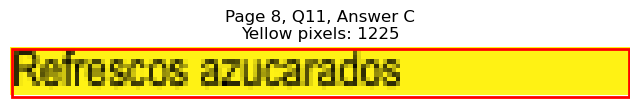

Page 8, Q11 - D: Detected box: x0=327.5, y0=671.7, x1=403.2, y1=682.8
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 388
Page 8, Q11, D: Yellow percentage: 0.0%


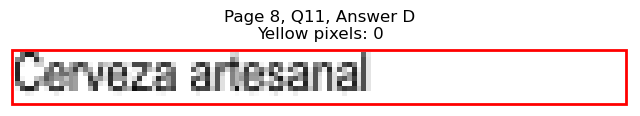


Page 8, Q11 - Selected Answer: C (based on yellow pixel count)




Page 8, Q12 - A: Detected box: x0=68.3, y0=734.8, x1=132.0, y1=745.9
Page 8, Q12, A: Yellow pixels: 0
Page 8, Q12, A: Total non-white pixels: 429
Page 8, Q12, A: Yellow percentage: 0.0%


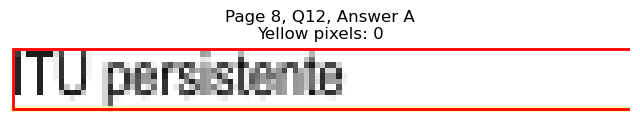

Page 8, Q12 - B: Detected box: x0=68.3, y0=747.4, x1=129.0, y1=758.5
Page 8, Q12, B: Yellow pixels: 996
Page 8, Q12, B: Total non-white pixels: 1332
Page 8, Q12, B: Yellow percentage: 74.8%


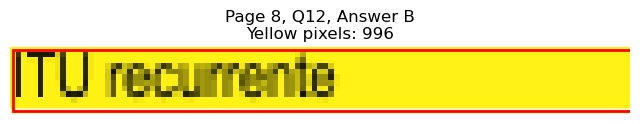

Page 8, Q12 - C: Detected box: x0=327.5, y0=734.8, x1=404.3, y1=745.9
Page 8, Q12, C: Yellow pixels: 0
Page 8, Q12, C: Total non-white pixels: 407
Page 8, Q12, C: Yellow percentage: 0.0%


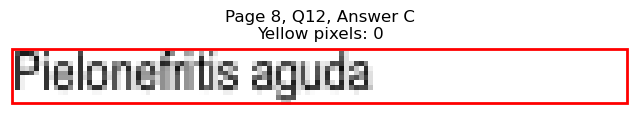

Page 8, Q12 - D: Detected box: x0=327.5, y0=747.4, x1=388.7, y1=758.5
Page 8, Q12, D: Yellow pixels: 0
Page 8, Q12, D: Total non-white pixels: 326
Page 8, Q12, D: Yellow percentage: 0.0%


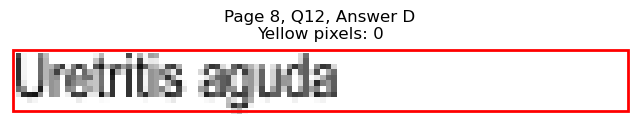


Page 8, Q12 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=109.0, y1=114.8
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 218
Page 9, Q1, A: Yellow percentage: 0.0%


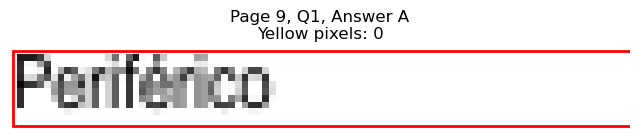

Page 9, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=99.8, y1=127.4
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 156
Page 9, Q1, B: Yellow percentage: 0.0%


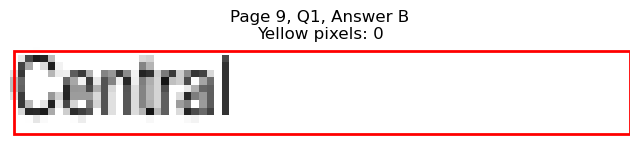

Page 9, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=378.6, y1=114.8
Page 9, Q1, C: Yellow pixels: 1023
Page 9, Q1, C: Total non-white pixels: 1224
Page 9, Q1, C: Yellow percentage: 83.6%


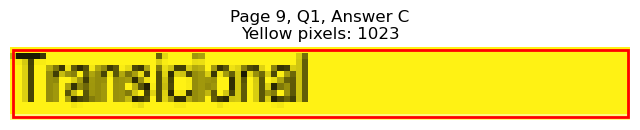

Page 9, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=420.2, y1=127.4
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 468
Page 9, Q1, D: Yellow percentage: 0.0%


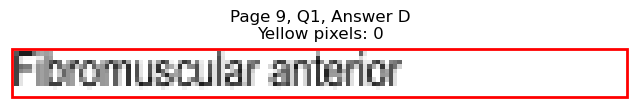


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=99.8, y1=177.9
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 226
Page 9, Q2, A: Yellow percentage: 0.0%


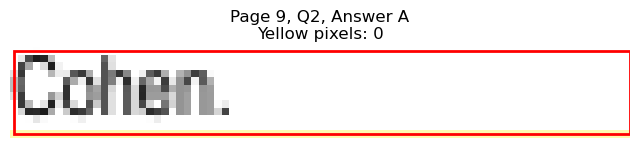

Page 9, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=116.4, y1=190.5
Page 9, Q2, B: Yellow pixels: 918
Page 9, Q2, B: Total non-white pixels: 1188
Page 9, Q2, B: Yellow percentage: 77.3%


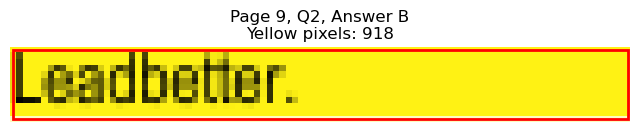

Page 9, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=382.2, y1=177.9
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 260
Page 9, Q2, C: Yellow percentage: 0.0%


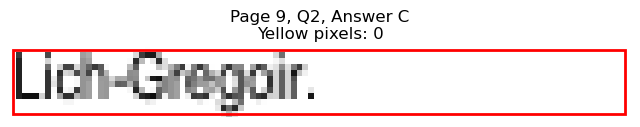

Page 9, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=368.6, y1=190.5
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 185
Page 9, Q2, D: Yellow percentage: 0.0%


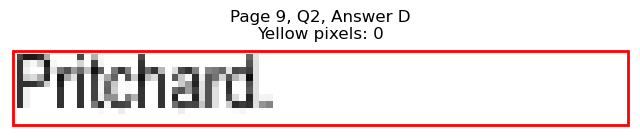


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=333.0, y1=228.4
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 1301
Page 9, Q3, A: Yellow percentage: 0.0%


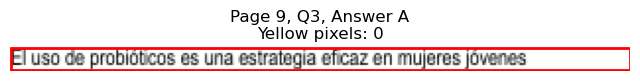

Page 9, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=402.8, y1=241.0
Page 9, Q3, B: Yellow pixels: 385
Page 9, Q3, B: Total non-white pixels: 2365
Page 9, Q3, B: Yellow percentage: 16.3%


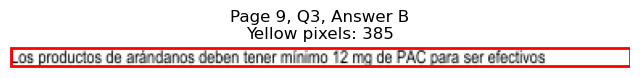

Page 9, Q3 - C: Detected box: x0=68.8, y0=242.6, x1=369.7, y1=253.6
Page 9, Q3, C: Yellow pixels: 2712
Page 9, Q3, C: Total non-white pixels: 4224
Page 9, Q3, C: Yellow percentage: 64.2%


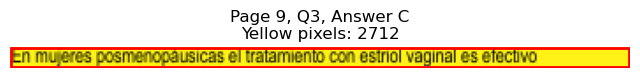

Page 9, Q3 - D: Detected box: x0=68.8, y0=255.2, x1=297.0, y1=266.2
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 1061
Page 9, Q3, D: Yellow percentage: 0.0%


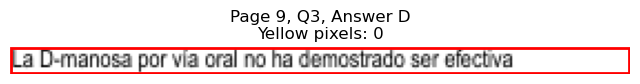


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=189.1, y1=304.2
Page 9, Q4, A: Yellow pixels: 172
Page 9, Q4, A: Total non-white pixels: 938
Page 9, Q4, A: Yellow percentage: 18.3%


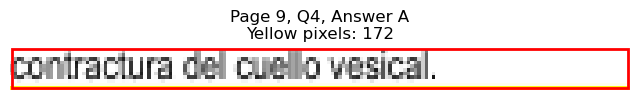

Page 9, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=145.0, y1=316.8
Page 9, Q4, B: Yellow pixels: 1224
Page 9, Q4, B: Total non-white pixels: 1524
Page 9, Q4, B: Yellow percentage: 80.3%


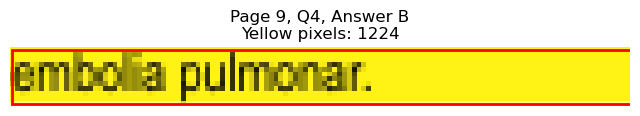

Page 9, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=358.1, y1=304.2
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 154
Page 9, Q4, C: Yellow percentage: 0.0%


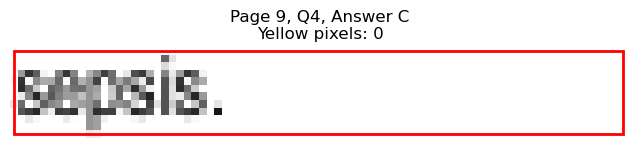

Page 9, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=378.1, y1=316.8
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 248
Page 9, Q4, D: Yellow percentage: 0.0%


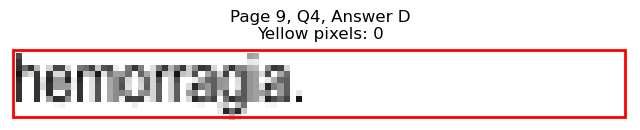


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=252.8, y1=367.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 892
Page 9, Q5, A: Yellow percentage: 0.0%


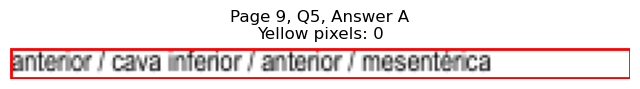

Page 9, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=222.7, y1=379.9
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 719
Page 9, Q5, B: Yellow percentage: 0.0%


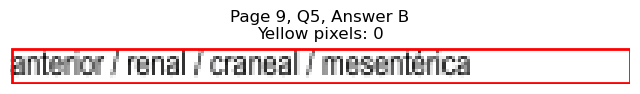

Page 9, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=457.4, y1=367.3
Page 9, Q5, C: Yellow pixels: 181
Page 9, Q5, C: Total non-white pixels: 800
Page 9, Q5, C: Yellow percentage: 22.6%


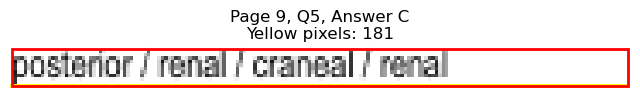

Page 9, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=486.4, y1=379.9
Page 9, Q5, D: Yellow pixels: 1949
Page 9, Q5, D: Total non-white pixels: 2520
Page 9, Q5, D: Yellow percentage: 77.3%


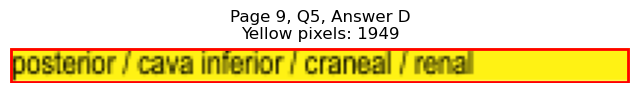


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=56.6, y0=419.4, x1=65.2, y1=430.4
Page 9, Q6, A: Yellow pixels: 60
Page 9, Q6, A: Total non-white pixels: 128
Page 9, Q6, A: Yellow percentage: 46.9%


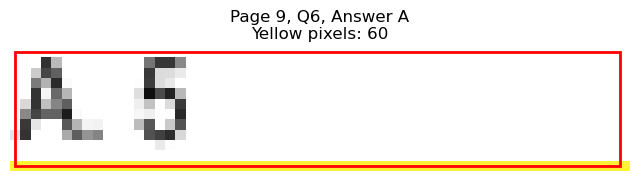

Page 9, Q6 - B: Detected box: x0=56.6, y0=432.0, x1=65.2, y1=443.0
Page 9, Q6, B: Yellow pixels: 666
Page 9, Q6, B: Total non-white pixels: 720
Page 9, Q6, B: Yellow percentage: 92.5%


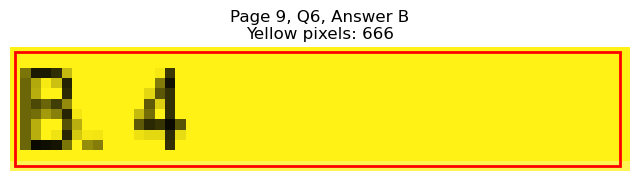

Page 9, Q6 - C: Detected box: x0=315.4, y0=419.4, x1=324.4, y1=430.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 64
Page 9, Q6, C: Yellow percentage: 0.0%


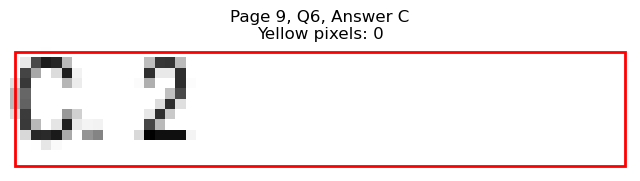

Page 9, Q6 - D: Detected box: x0=315.4, y0=432.0, x1=324.4, y1=443.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 72
Page 9, Q6, D: Yellow percentage: 0.0%


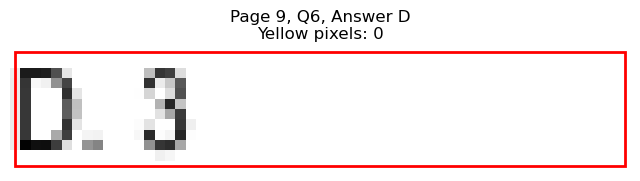


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=137.5, y1=480.8
Page 9, Q7, A: Yellow pixels: 1145
Page 9, Q7, A: Total non-white pixels: 1440
Page 9, Q7, A: Yellow percentage: 79.5%


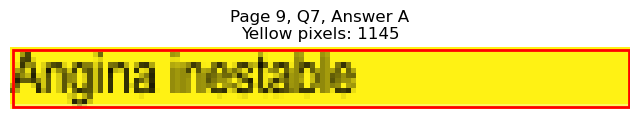

Page 9, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=166.1, y1=493.5
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 518
Page 9, Q7, B: Yellow percentage: 0.0%


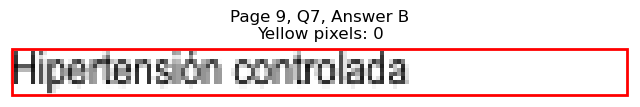

Page 9, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=434.3, y1=480.8
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 561
Page 9, Q7, C: Yellow percentage: 0.0%


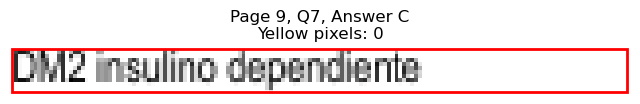

Page 9, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=400.7, y1=493.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 371
Page 9, Q7, D: Yellow percentage: 0.0%


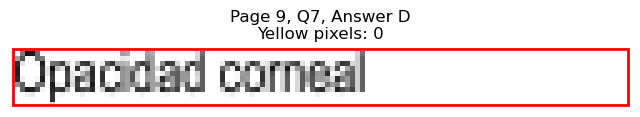


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=165.1, y1=556.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 481
Page 9, Q8, A: Yellow percentage: 0.0%


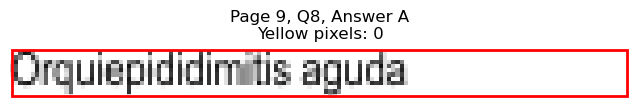

Page 9, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=139.4, y1=569.2
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 353
Page 9, Q8, B: Yellow percentage: 0.0%


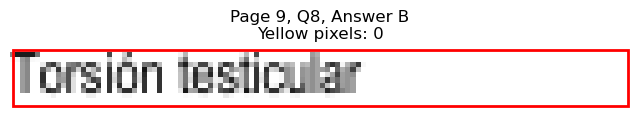

Page 9, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=418.8, y1=556.5
Page 9, Q8, C: Yellow pixels: 1239
Page 9, Q8, C: Total non-white pixels: 1704
Page 9, Q8, C: Yellow percentage: 72.7%


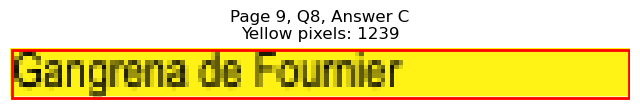

Page 9, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=395.6, y1=569.2
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 364
Page 9, Q8, D: Yellow percentage: 0.0%


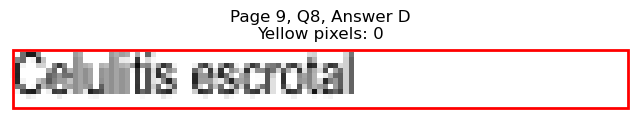


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=596.0, x1=124.6, y1=607.0
Page 9, Q9, A: Yellow pixels: 1136
Page 9, Q9, A: Total non-white pixels: 1284
Page 9, Q9, A: Yellow percentage: 88.5%


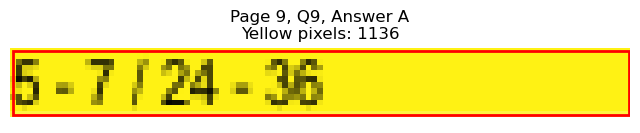

Page 9, Q9 - B: Detected box: x0=68.3, y0=608.6, x1=124.4, y1=619.6
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 177
Page 9, Q9, B: Yellow percentage: 0.0%


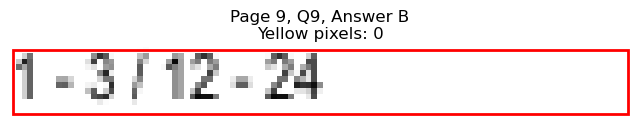

Page 9, Q9 - C: Detected box: x0=327.5, y0=596.0, x1=383.6, y1=607.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 209
Page 9, Q9, C: Yellow percentage: 0.0%


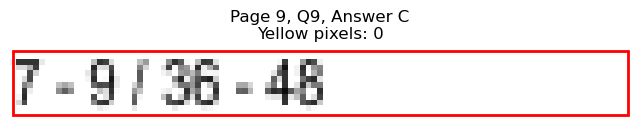

Page 9, Q9 - D: Detected box: x0=327.5, y0=608.6, x1=381.1, y1=619.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 172
Page 9, Q9, D: Yellow percentage: 0.0%


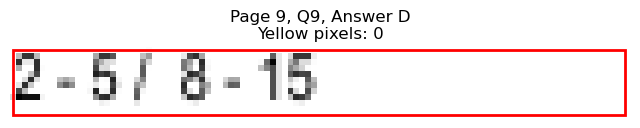


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 45 años con dolor lumbar derecho recu...
1   Mujer de 55 años con escape de orina a grandes...
2   ¿Cuál es la causa más frecuente de estenosis u...
3   Mujer joven sin comorbilidades con 2 días de m...
4   ¿Cuál es la hormona que estimula la espermatog...
..                                                ...
95  La vena suprarrenal derecha es corta y entra e...
96  En la resonancia multiparamétrica de próstata ...
97  ¿Cuál es una contraindicación para indicar inh...
98  Varón de 54 años, desde hace 2 días presenta f...
99  La vida media de los marcadores tumorales es: ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                             Ureterolitotricia láser   
1                    IUU + prolapso posterior grado 2   
2                                            Isquemia   
3                                      Cistitis aguda   
4                                                 FSH   
..                                                ...   
95  anterior / cava inferior / anterior / mesentérica   
96                                                  5   
97                                   Angina inestable   
98                            Orquiepididimitis aguda   
99                                    5 - 7 / 24 - 36   

                                    option_B  \
0                   Litotricia extracorpórea   
1            IUE + prolapso anterior grado 3   
2                         Rechazo de injerto   
3                             Hematoma renal   
4                                         LH   
..                                       ...   
95  anterior / renal / craneal / mesentérica   
96                                         4   
97                   Hipertensión controlada   
98                        Torsión testicular   
99                           1 - 3 / 12 - 24   

                               option_C  \
0            Nefrolitotricia percutánea   
1       IUE + prolapso anterior grado 2   
2                     Infección por CMV   
3                   Cólico renoureteral   
4                            Prolactina   
..                                  ...   
95  posterior / renal / craneal / renal   
96                                    2   
97             DM2 insulino dependiente   
98                 Gangrena de Fournier   
99                      7 - 9 / 36 - 48   

                                       option_D  
0                  Pielolitotomía laparoscópica  
1              IUU + prolapso posterior grado 3  
2                                     Hematuria  
3                           Pielonefritis aguda  
4                                     Oxitocina  
..                                          ...  
95  posterior / cava inferior / craneal / renal  
96                                            3  
97                             Opacidad corneal  
98                           Celulitis escrotal  
99                              2 - 5 /  8 - 15  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 45 años con dolor lumbar derecho recu...   
1   Mujer de 55 años con escape de orina a grandes...   
2   ¿Cuál es la causa más frecuente de estenosis u...   
3   Mujer joven sin comorbilidades con 2 días de m...   
4   ¿Cuál es la hormona que estimula la espermatog...   
..                                                ...   
95  La vena suprarrenal derecha es corta y entra e...   
96  En la resonancia multiparamétrica de próstata ...   
97  ¿Cuál es una contraindicación para indicar inh...   
98  Varón de 54 años, desde hace 2 días presenta f...   
99  La vida media de los marcadores tumorales es: ...   

                                             option_A  \
0                             Ureterolitotricia láser   
1                    IUU + prolapso posterior grado 2   
2                                            Isquemia   
3                                      Cistitis aguda   
4                                                 FSH   
..                                                ...   
95  anterior / cava inferior / anterior / mesentérica   
96                                                  5   
97                                   Angina inestable   
98                            Orquiepididimitis aguda   
99                                    5 - 7 / 24 - 36   

                                    option_B  \
0                   Litotricia extracorpórea   
1            IUE + prolapso anterior grado 3   
2                         Rechazo de injerto   
3                             Hematoma renal   
4                                         LH   
..                                       ...   
95  anterior / renal / craneal / mesentérica   
96                                         4   
97                   Hipertensión controlada   
98                        Torsión testicular   
99                           1 - 3 / 12 - 24   

                               option_C  \
0            Nefrolitotricia percutánea   
1       IUE + prolapso anterior grado 2   
2                     Infección por CMV   
3                   Cólico renoureteral   
4                            Prolactina   
..                                  ...   
95  posterior / renal / craneal / renal   
96                                    2   
97             DM2 insulino dependiente   
98                 Gangrena de Fournier   
99                      7 - 9 / 36 - 48   

                                       option_D correct_answer  
0                  Pielolitotomía laparoscópica              A  
1              IUU + prolapso posterior grado 3              B  
2                                     Hematuria              A  
3                           Pielonefritis aguda              D  
4                                     Oxitocina              A  
..                                          ...            ...  
95  posterior / cava inferior / craneal / renal              D  
96                                            3              B  
97                             Opacidad corneal              A  
98                           Celulitis escrotal              C  
99                              2 - 5 /  8 - 15              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/UROLOGIA.csv
